In [2]:
import os
import re
import sys
import glob
import json
import shutil
import cc3d
import mlxtend
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
from scipy import stats
import statsmodels.api as sm
from typing import Dict, List
from scipy import stats
from nilearn import plotting
from tqdm.notebook import tqdm
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_linear_regression
import xml.etree.ElementTree as ET

sys.path.append('..')
from misc_utils import *
warnings.filterwarnings("ignore")

In [3]:
meta_info = misc_meta()
with open('/home/socrates/david/tsc/codebase/data/NEW_INTEG.json', 'r') as f:
    NEW_INTEG = json.load(f)

In [4]:
# save_addr = "./new_integ_04292021.csv"
# namechange = {'pred_reg2tp':'pred_inter_both_reg2tp',
#               'pred_reg2tp_thr0.5': 'pred_inter_both_reg2tp_thr0.5',
#               'mask_orig': 'mask_orig1',              
#              }
# ## Aggregate all keys
# all_keys = []
# for mod in NEW_INTEG.keys():
#     for sid in NEW_INTEG[mod].keys():
#         for k in NEW_INTEG[mod][sid].keys():
#             if k not in all_keys:
#                 all_keys.append(k)
#             if k == 'mask_orig':
#                 NEW_INTEG[mod][sid]['mask_orig1'] = NEW_INTEG[mod][sid]['mask_orig']
#                 del NEW_INTEG[mod][sid]['mask_orig']
# ## make a pandas dataframe
# all_keys_update = [namechange[k] if k in namechange.keys()  else k for k in all_keys]
# all_keys_update
# towrite = 'mod,sid,' + ','.join(all_keys_update) + '\n'

# # Save it as a csv file
# for mod in NEW_INTEG.keys():
#     for sid in NEW_INTEG[mod].keys():
#         towrite += '{},{},'.format(mod, sid)
#         togo = []
#         for k in all_keys:
#             if k == 'mask_orig':
#                 continue
#             if k in NEW_INTEG[mod][sid].keys():
#                 togo.append(NEW_INTEG[mod][sid][k])
#             else:
#                 togo.append('empty')
#         towrite += ','.join(togo) + '\n'
            
# with open(save_addr, 'w') as f:
#     f.write(towrite)

In [5]:
save_addr = "./new_integ_04292021.csv"
INTEG_DF = pd.read_csv(save_addr)
INTEG_DF['mask_FL_reg2tp_thr0.5']

0     /home/socrates/david/tsc/codebase/data/train/1...
1     /home/socrates/david/tsc/codebase/data/train/1...
2     /home/socrates/david/tsc/codebase/data/train/1...
3     /home/socrates/david/tsc/codebase/data/train/2...
4     /home/socrates/david/tsc/codebase/data/train/2...
5     /home/socrates/david/tsc/codebase/data/train/2...
6     /home/socrates/david/tsc/codebase/data/train/3...
7     /home/socrates/david/tsc/codebase/data/train/3...
8     /home/socrates/david/tsc/codebase/data/train/4...
9     /home/socrates/david/tsc/codebase/data/train/4...
10    /home/socrates/david/tsc/codebase/data/train/4...
11    /home/socrates/david/tsc/codebase/data/train/4...
12    /home/socrates/david/tsc/codebase/data/train/4...
13    /home/socrates/david/tsc/codebase/data/train/4...
14    /home/socrates/david/tsc/codebase/data/train/5...
15    /home/socrates/david/tsc/codebase/data/train/5...
16    /home/socrates/david/tsc/codebase/data/train/5...
17    /home/socrates/david/tsc/codebase/data/tra

In [6]:
for idx, line in INTEG_DF.iterrows():
    print(line['mod'])
    break

train


In [7]:
class Results_Figures():
    
    def __init__(self, integ_addr):
        self.INTEG = pd.read_csv(integ_addr)
        self.meta = misc_meta()
        self.result_dir = '../../results'
        
    def correlate_tuber_size_intensity(self, mod = 'train', group = False):
        """
        Print results and figures showing the correlation of tuber size and intensity.
        Inputs:
            mod = ['train', 'test', 'all']
        """
        mean_dir = os.path.join(self.result_dir, 'figures', 'correlate_tuber_size_intensity_mean')
        std_dir = os.path.join(self.result_dir, 'figures', 'correlate_tuber_size_intensity_std')
        makedir(mean_dir)
        makedir(std_dir)
        
        if mod == 'all':
            target_df = self.INTEG
        else:
            target_df = select(self.INTEG, 'mod', mod)
            
        result_dict = {}
        n_tuber_list, pvalue_list = [], []
        group_x, group_y, group_y_std = [], [], []
        for idx, subject in INTEG_DF.iterrows(): 
            
            mask = subject['mask_inter'] if subject['mod'] == 'train' else subject['mask_orig1']
                
            flair, brain_mask = subject['FL_brain'], subject['mask_FL_brain']

            x, y, y_std = [], [], []

            flair_np = znormalize(nib.load(flair).get_fdata())
            mask_np = nonzero_to_one(eye_to_zero(nib.load(mask).get_fdata())).astype('int')
            mask_cc3d = cc3d.connected_components(mask_np)
            n_tuber_list.append(len(np.unique(mask_cc3d)))

            brainmask_file = brain_mask
            brain_voxel, brain_volume = compute_volumn(brainmask_file)          

            for label in np.unique(mask_cc3d)[1:]:

                booled = mask_cc3d==label
                masked_flair = flair_np * booled

                roi_voxel, roi_volume = compute_volumn(brainmask_file, booled)
                assert roi_volume < brain_volume*0.5, 'just to confirm roi is not the background'
                # Average roi
                roi_intensity_mean = masked_flair[masked_flair!=0].mean()
                roi_intensity_std = masked_flair[masked_flair!=0].mean()

                x.append(np.log10(roi_volume))
                y.append(roi_intensity_mean)
                y_std.append(roi_intensity_std)
                group_x.append(np.log10(roi_volume))
                group_y.append(roi_intensity_mean)
                group_y_std.append(roi_intensity_std)
            print('subject id'.format(subject['sid']))
            print('average intensity: {}'.format(np.array(y).mean()))
            
            ## Plotting code - intensity mean ##
            _, ax = plt.subplots(1, 1, figsize=(15, 5))    
            ax.scatter(x=x, y=y)
            ax.set_xlabel(r'$log_{10}$ roi_volume ($mm^3$)')
            ax.set_ylabel('tuber intensity - mean ')    
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            pvalue_list.append(p_value)
            
            ax.plot(np.array(x), intercept + slope * np.array(x), 'gray', linestyle='-', label='p value = {:.2e}'.format(p_value))
            ax.legend(fontsize=9)
            
            plt.savefig(os.path.join(mean_dir, 'sid_{}'.format(subject['sid'])))
            
            ## Plotting code - intensity_std ##
            _, ax = plt.subplots(1, 1, figsize=(15, 5))    
            ax.scatter(x=x, y=y_std)
            ax.set_xlabel(r'$log_{10}$ roi_volume ($mm^3$)')
            ax.set_ylabel('reversed tuber intensity - std')    
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y_std)
            pvalue_list.append(p_value)
            
            ax.plot(np.array(x), intercept + slope * np.array(x), 'gray', linestyle='-', label='p value = {:.2e}'.format(p_value))
            ax.legend(fontsize=9)
            plt.savefig(os.path.join(std_dir, 'sid_{}'.format(subject['sid'])))
            
        print('average tuber: {:.2f}'.format(np.array(n_tuber_list).mean()))
        result_dict['ntuber'] = n_tuber_list
        result_dict['pvalue'] = pvalue_list
        
        if group == True:
            
            ## Group plotting code - intensity mean ##
            _, ax = plt.subplots(1, 1, figsize=(15, 5))    
            ax.scatter(x=group_x, y=group_y)
            ax.set_xlabel(r'$log_{10}$ roi_volume ($mm^3$)')
            ax.set_ylabel('tuber intensity - mean ')   
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(group_x, group_y)

            ax.plot(np.array(group_x), intercept + slope * np.array(group_x), 'gray', linestyle='-', label='p value = {:.2e}'.format(p_value))
            ax.legend(fontsize=12)            
            plt.savefig(os.path.join(mean_dir, 'group_level'))
            
            ## Group plotting code - intensity std ##
            _, ax = plt.subplots(1, 1, figsize=(15, 5))
            ax.scatter(x=group_x, y=group_y_std)
            ax.set_xlabel(r'$log_{10}$ roi_volume ($mm^3$)')
            ax.set_ylabel('tuber intensity - std')  
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(group_x, group_y_std)

            ax.plot(np.array(group_x), intercept + slope * np.array(group_x), 'gray', linestyle='-', label='p value = {:.2e}'.format(p_value))
            ax.legend(fontsize=12)
            plt.savefig(os.path.join(std_dir, 'group_level'))

        return result_dict
    
    def threhold_based_inference(self):
        ## Distribution including the test dataset
        save_dir = os.path.join(self.result_dir, 'figures', 'threhold_based_inference')
        makedir(save_dir)
        flairall, y, test_y= [], [], []
        for idx, subject in tqdm(self.INTEG.iterrows()): 
            if subject['mod'] == 'train':
                flair, mask, brain_mask = subject['FL_brain'], subject['mask_inter'], subject['mask_FL_brain']  
            elif  subject['mod'] == 'test':
                flair, mask, brain_mask = subject['FL_brain'], subject['mask_orig1'], subject['mask_FL_brain']
            else:
                assert False            
                    
            brain_np = nib.load(brain_mask).get_fdata() * znormalize(nib.load(flair).get_fdata())
            flair_np = znormalize(nib.load(flair).get_fdata())
            flairall += list(flair_np[flair_np>0.5])
            
            mask_np = nonzero_to_one(eye_to_zero(nib.load(mask).get_fdata())).astype('int')
            mask_cc3d = cc3d.connected_components(mask_np)

            brain_voxel, brain_volume = compute_volumn(brain_mask)          

            for label in np.unique(mask_cc3d)[1:]:

                booled = mask_cc3d==label
                masked_flair = flair_np * booled
                roi_intensity = list(masked_flair[masked_flair>0])
                if subject['mod'] == 'train':
                    y += roi_intensity
                elif  subject['mod'] == 'test':
                    test_y += roi_intensity
                else:
                    assert False

        # Got from somewhere else
        opt_threshold = 2.54

        fig = plt.figure(figsize=(15, 12))
        ax1 = fig.add_subplot(311)
        sns.distplot(flairall, color='black')
        ax1.set_title('Brain intensity density', color='black', fontsize=12)
        ax1.axvline(opt_threshold, 0,1.0, c='black', ls='--', lw=2.0, label='threshold at x = {}'.format(opt_threshold))
        ax1.set_xlim(0.5,5)
        ax1.legend(fontsize=12)

        ax2 = fig.add_subplot(312)
        sns.distplot(y, color='skyblue')
        ax2.set_title('Tuber intensity density - train set', color='black', fontsize=12)
        ax2.axvline(opt_threshold, 0,1.0,  c='black', ls='--', lw=3.0, label='threshold x = {}'.format(opt_threshold))
        ax2.set_xlim(0.5,5)

        ax3 = fig.add_subplot(313)
        sns.distplot(test_y, color='orange')
        ax3.set_title('Tuber intensity density - test set', color='black', fontsize=12)
        ax3.axvline(opt_threshold, 0,1.0,  c='black', ls='--', lw=3.0,label='threshold x = {}'.format(opt_threshold))
        ax3.set_xlim(0.5,5)
        plt.savefig(os.path.join(save_dir, 'complete'))
        plt.show()
        return 0
        
    
    def distribution_gross_tubers(self):
        """
        Plot distibution of tuber-level variables, all in one plot (brain-level)
        """
        save_dir = os.path.join(self.result_dir, 'figures', 'distribution_brain_level')
        makedir(save_dir)
        n_tuber = []
        size_tuber = []
        intensity_mean_tuber = []
        intensity_std_tuber = []
        for idx, subject in self.INTEG.iterrows(): 

            mask = subject['mask_inter'] if subject['mod'] == 'train' else subject['mask_orig1']                
            flair, brain_mask = subject['FL_brain'], subject['mask_FL_brain']

            flair_np = znormalize(nib.load(flair).get_fdata())
            mask_np = nonzero_to_one(eye_to_zero(nib.load(mask).get_fdata())).astype('int')
            mask_cc3d = cc3d.connected_components(mask_np)
            n_tuber.append(len(np.unique(mask_cc3d)))
            for label in np.unique(mask_cc3d)[1:]:
                booled = mask_cc3d==label
                masked_flair = flair_np * booled
                _, roi_volume = compute_volumn(flair, booled)
                size_tuber.append(roi_volume)
                roi_intensity = masked_flair[masked_flair!=0].mean()
                roi_intensity_std = masked_flair[masked_flair!=0].std()
                intensity_mean_tuber.append(roi_intensity)
                intensity_std_tuber.append(roi_intensity_std)
                
        ax = sns.displot(n_tuber).set(title="# of tubers across subjects", 
                                                    ylabel='number of tubers')
        plt.savefig(os.path.join(save_dir, 'ntuber'))
        plt.show()
        
        ax = sns.displot(np.log10(np.array(size_tuber))).set(title="size distribution for all tubers", 
                                                                          ylabel=r'$log10(size) in mm^3$')
        plt.savefig(os.path.join(save_dir, 'sizetuber'))
        plt.show()
        
        ax = sns.displot(intensity_mean_tuber ).set(title="distribution of intensity mean for all tubers", 
                                                                           ylabel='intensity mean')
        plt.savefig(os.path.join(save_dir, 'intensity_mean'))
        plt.show()
        
        ax = sns.displot(intensity_std_tuber).set(title="distribution of intensity std for all tubers", 
                                                                           ylabel='intensity standard deviation')
        plt.savefig(os.path.join(save_dir, 'intensity_std'))
        plt.show()
        return 0
        
    def distribution_lobe_tubers(self, lobe_level_indiv_stats, var, var_sub='mean'):
        """
        For individuals, lobe-level tuber summary.
        For group, subject-level summary.
        """
        indiv_dir = os.path.join(self.result_dir, 'figures', 'lobe_level_subject_distribution', var)
        group_dir = os.path.join(self.result_dir, 'figures', 'lobe_level_group_distribution', var)
        makedir(indiv_dir)
        makedir(group_dir)
        lobe_level_dist = {str(i):[] for i in self.meta['major_lobes']} 
        
        for sid in lobe_level_indiv_stats.keys():
            indiv_stats = lobe_level_indiv_stats[sid]
            if var == 'area':
                indiv_stats = {lo:np.log10(indiv_stats[lo]+1) for lo in indiv_stats.keys()}
            for lobe in indiv_stats.keys():
                lobe_level_dist[lobe].append(indiv_stats[lobe])            
            
            
                print_sid = self.meta['testid2orig'][self.meta['test2id'][sid]] if int(sid) >= 100 else sid
#             # individual lobe-level distribution of tuber stat
            sns.set_style("whitegrid")
            fig, axs = plt.subplots(1,1, figsize=(10, 5))
            sns.barplot(ax = axs,
                x = [self.meta['idx2atlas_lr'][l] for l in list(indiv_stats.keys())], 
                y = np.array(list(indiv_stats.values())) 
               )
            axs.set_title('subject {}'.format(print_sid))
            axs.set_ylabel('tuber {}'.format(var))
            for tick in axs.get_xticklabels():
                tick.set_rotation(45)    
            if var == 'intensity':
                plt.savefig(os.path.join(indiv_dir, '{}_per_lobe_sid{}_{}'.format(var, print_sid, var_sub)))
            else:
                plt.savefig(os.path.join(indiv_dir, '{}_per_lobe_sid{}'.format(var, print_sid)))
            plt.show()
            
        # Group-level distribution of lobes
        sns.set_style("whitegrid")
        fig, axs = plt.subplots(2,4, figsize=(15, 10))
        if var == 'area':
            newBins = np.linspace(0, 5, 25)
        elif var == 'ntuber':
            newBins = np.linspace(0, 20, 20)
        elif var == 'intensity':
            newBins = np.linspace(-3.5, 3.5, 50)
            
        fig.tight_layout(h_pad=4)
        for idx, lobe in enumerate(lobe_level_dist.keys()):
            a_ = (idx) //4 
            b_ = (idx) % 4
            sns.distplot(lobe_level_dist[lobe], 
                         ax = axs[a_,b_], 
                         color = 'red', bins=newBins)
            if var == 'area':
                axs[a_,b_].set_xlim(1.0, 5.0)
            elif var == 'ntuber':
                axs[a_,b_].set_xlim(0, 20)
            elif var == 'intensity':
                axs[a_,b_].set_xlim(0, 3.5)
            
            axs[a_,b_].set_title(self.meta['idx2atlas_lr'][lobe])
            axs[a_,b_].set_ylabel('tuber {} density'.format(var))
        if var == 'intensity':
            plt.savefig(os.path.join(group_dir, '{}_per_lobe_group_{}'.format(var, var_sub)))
        else: 
            plt.savefig(os.path.join(group_dir, '{}_per_lobe_group'.format(var)))
        plt.show()
    
    def indiv_glass_brain(self, mod = 'mask_FL_reg2tp_thr0.5', save_fig = True):
        """
        Given mni-registered mask, save the glass brain visualization
        """
        save_dir = os.path.join(self.result_dir, 'figures', 'individual_glass_brain')        
        
        for idx, subject in self.INTEG.iterrows():
            mni_mask_addr = subject[mod]           
            
            mask = nib.load(mni_mask_addr)
            display = plotting.plot_glass_brain(None)
            display.add_contours(mask, colors=['#ffeec9','pink', 'red', 'red'], filled=True)
            display.add_contours(mask, colors=['pink', 'red', 'red'])
            if save_fig:
                makedir(os.path.join(save_dir, '{}'.format(mod)))
                save_addr = os.path.join(save_dir, '{}'.format(mod), 'sid{}.png'.format(subject['sid']))
                display.savefig(save_addr)
            plt.show()
        return 0
    
    def indiv_glass_brain_with_epileptogenic(self, mod = 'mask_FL_reg2tp_thr0.5', save_fig = True):
        save_dir = os.path.join(self.result_dir, 'figures', 'individual_glass_brain_with_epileptogenic')
        
        atlas = nib.load('/home/socrates/david/tsc/TSCseg/data/atlas/atlas_lf.nii')
        atlas_np = atlas.get_fdata()

        for idx, subject in self.INTEG.iterrows():
            mni_mask_addr = subject[mod]
            mni_mask = nib.load(mni_mask_addr)

            sid_int = subject['sid']
            sid_orig = self.meta['orig2test'][str(sid_int)] if subject['mod']=='test' else str(sid_int) 
            if sid_orig in self.meta['pid2eeglobe'].keys():
                focus_lobes = self.meta['pid2eeglobe'][sid_orig]
                focus_all_np = np.zeros(atlas_np.shape)

                for lobe_id in focus_lobes:        
                    atlas_lobe = atlas_np==int(lobe_id)
                    focus_all_np += atlas_lobe

                focus_all = nib.Nifti1Image(focus_all_np.astype('int32'), atlas.affine, atlas.header)

                display = plotting.plot_glass_brain(None)
                display.add_contours(focus_all, colors=['#3d98ff'], alpha=0.2, filled=True)
                display.add_contours(mni_mask, colors=['#ffeec9','pink', 'red', 'red'], filled=True)
                display.add_contours(mni_mask, colors=['pink', 'red', 'red'])
                
                if save_fig:
                    makedir(os.path.join(save_dir, '{}'.format(mod)))
                    save_addr = os.path.join(save_dir, '{}'.format(mod), 'sid{}.png'.format(subject['sid']))
                    display.savefig(save_addr)
                plt.show()


In [8]:
EXP = Tuber_EXP(NEW_INTEG, meta_info)
EXP.load_stats(addr='./stats', version='v5')
Analyzer = Results_Figures(save_addr)

loaded from ./stats_v5.json


## 1. Correlations between tuber sizes and intensity

### tuber size positively correlated with the intensity mean / std

subject id
average intensity: 2.4341966467240024
subject id
average intensity: 2.8659600682943327
subject id
average intensity: 2.942559434224893
subject id
average intensity: 3.0783315700440625
subject id
average intensity: 2.675746481111022
subject id
average intensity: 2.2288937280426455
subject id
average intensity: 2.6696973677549587
subject id
average intensity: 2.6888955087516693
subject id
average intensity: 2.5316131594870006
subject id
average intensity: 2.531259694301703
subject id
average intensity: 2.114377318346009
subject id
average intensity: 2.9239315627788454
subject id
average intensity: 2.875727364239938
subject id
average intensity: 2.2141207150135327
subject id
average intensity: 2.7221479355089637
subject id
average intensity: 2.8382435822131526
subject id
average intensity: 2.6554639875943185
subject id
average intensity: 2.1744420188296067
subject id
average intensity: 2.2537270670000096
subject id
average intensity: 2.583356246381462
subject id
average intensi

{'ntuber': [54,
  11,
  64,
  25,
  25,
  38,
  24,
  37,
  11,
  54,
  37,
  39,
  21,
  37,
  12,
  13,
  5,
  3,
  29,
  3,
  12,
  32,
  5,
  23,
  12,
  28,
  3,
  37,
  16],
 'pvalue': [1.020465351482054e-05,
  1.020465351482054e-05,
  0.04405083708038326,
  0.04405083708038326,
  0.0010271045252686585,
  0.0010271045252686585,
  9.36394481835255e-06,
  9.36394481835255e-06,
  0.16077818043674424,
  0.16077818043674424,
  0.08507357927756194,
  0.08507357927756194,
  0.8032216821053569,
  0.8032216821053569,
  0.024952902002828976,
  0.024952902002828976,
  0.4777740869417151,
  0.4777740869417151,
  9.991669988699833e-05,
  9.991669988699833e-05,
  0.8143872912375454,
  0.8143872912375454,
  0.6342220384295034,
  0.6342220384295034,
  0.6274067701251046,
  0.6274067701251046,
  4.606295984711346e-05,
  4.606295984711346e-05,
  0.007183597015258567,
  0.007183597015258567,
  0.10504186715193617,
  0.10504186715193617,
  0.7522051682494895,
  0.7522051682494895,
  0.0,
  0.0,
  0.

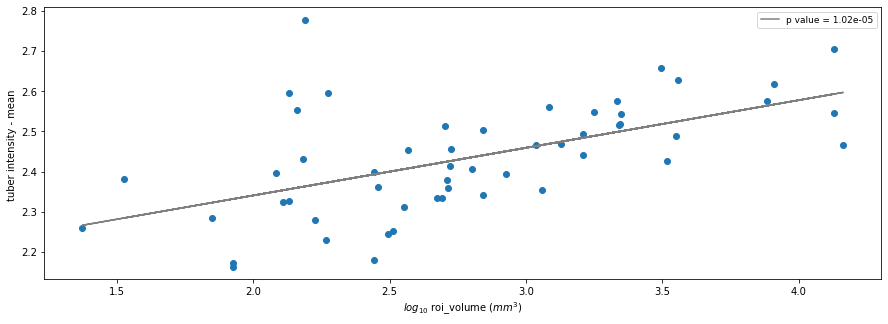

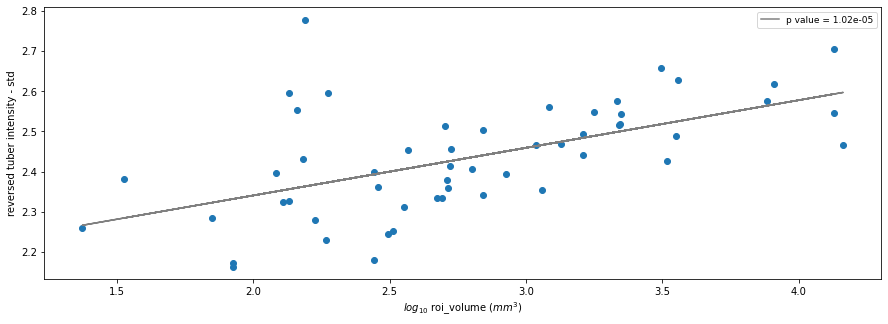

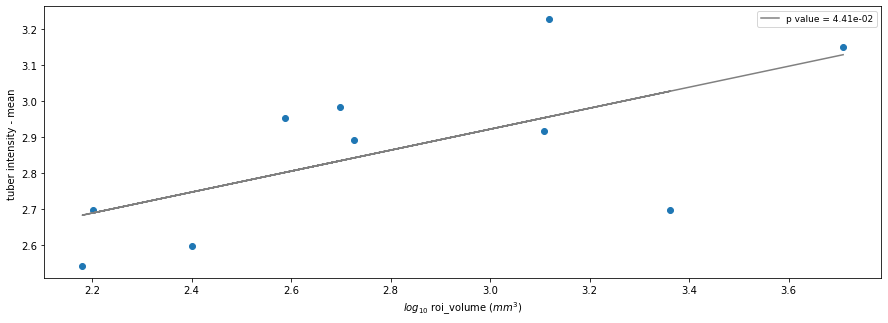

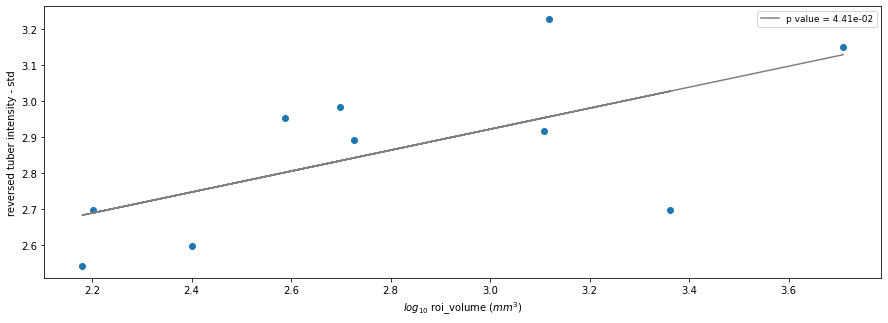

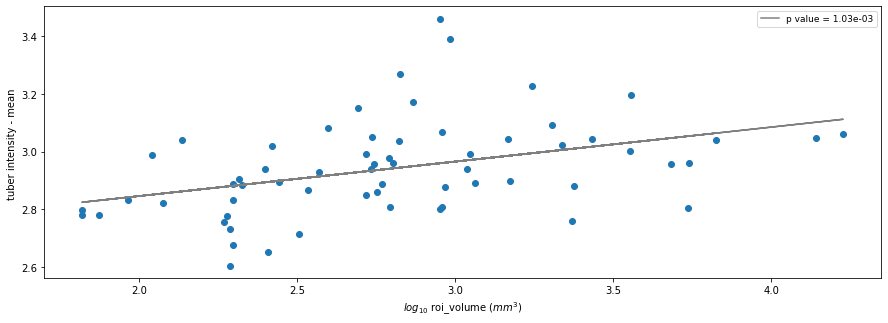

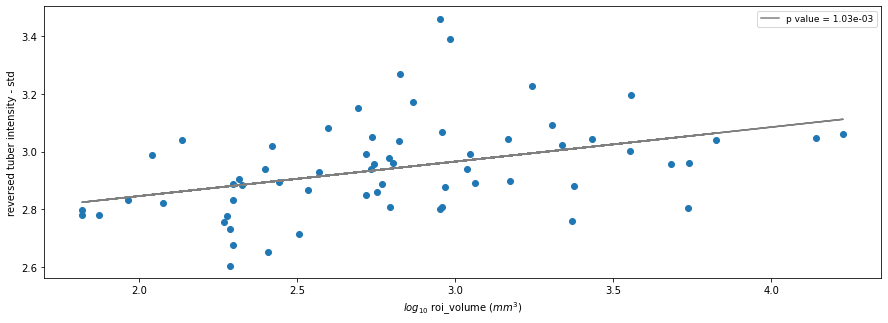

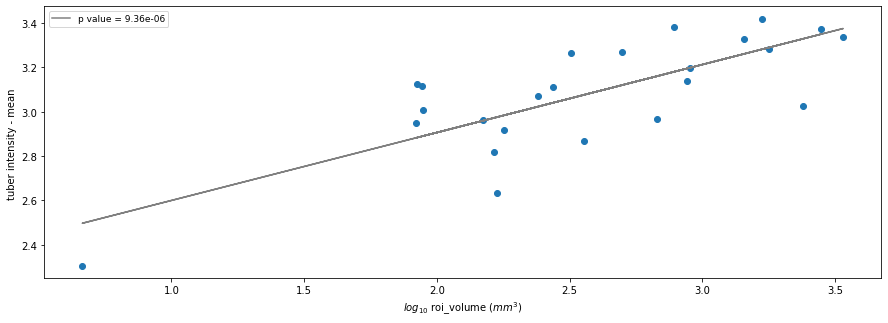

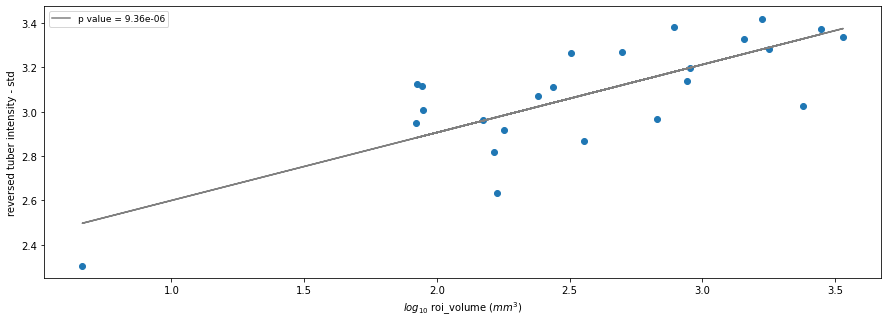

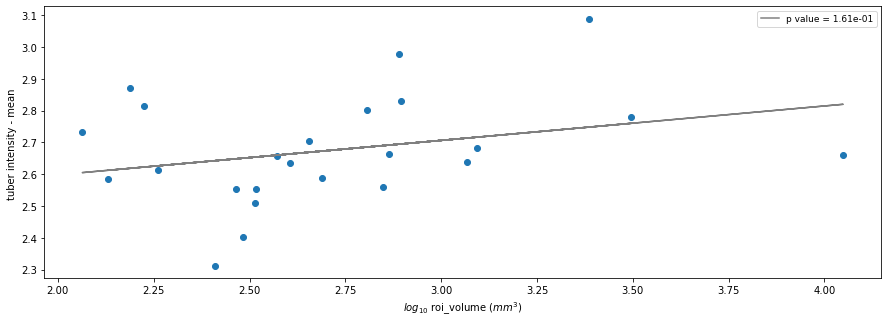

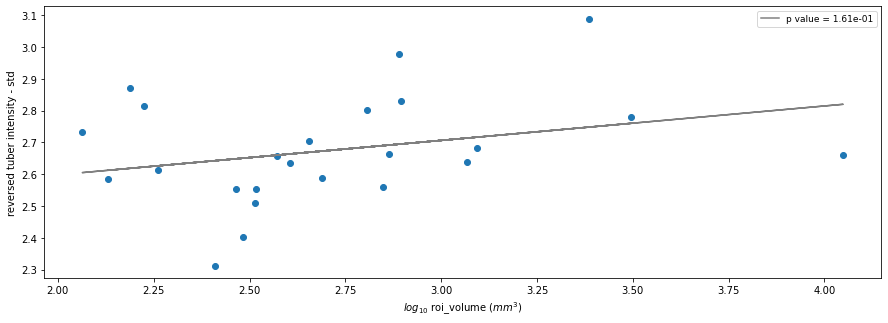

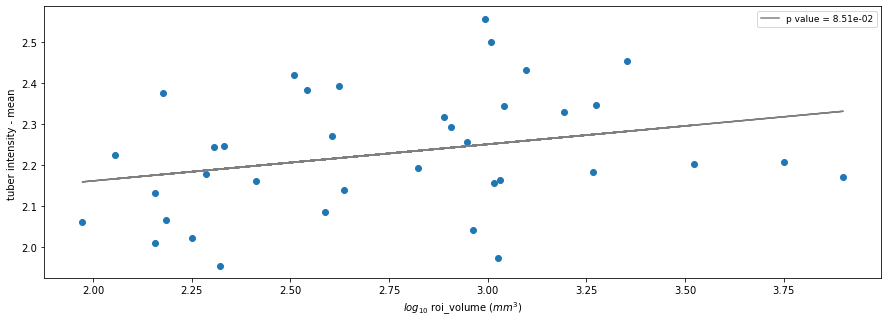

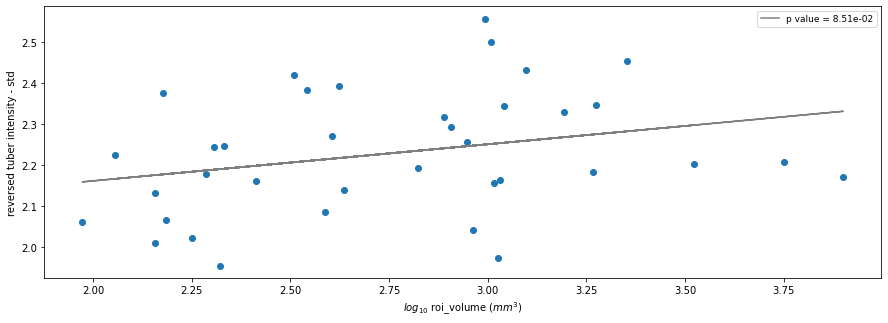

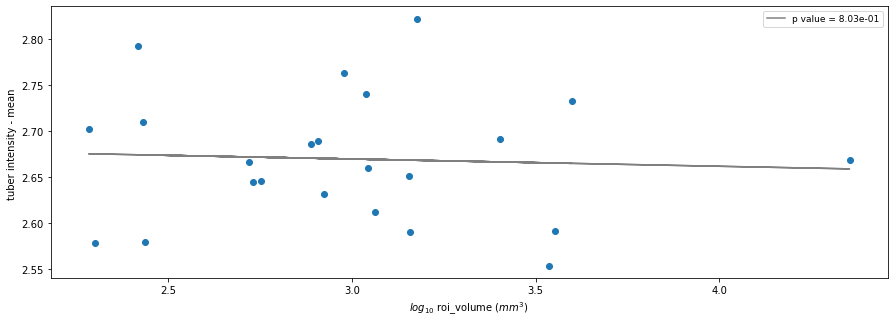

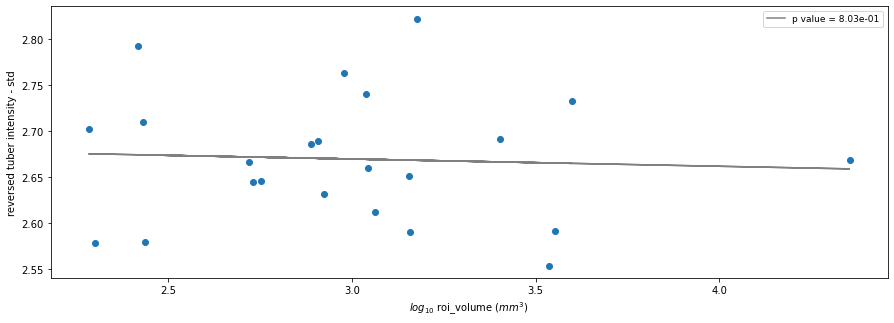

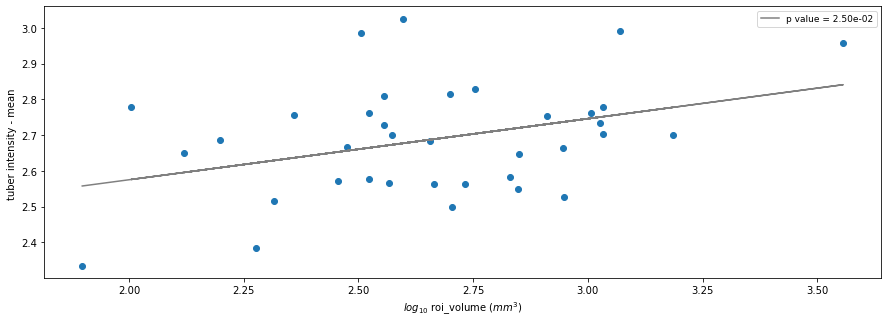

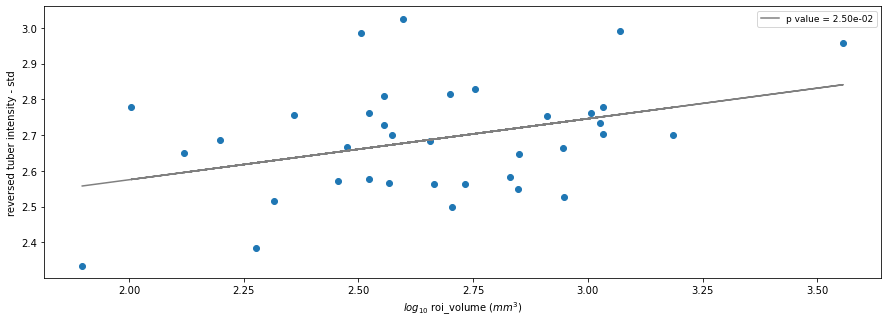

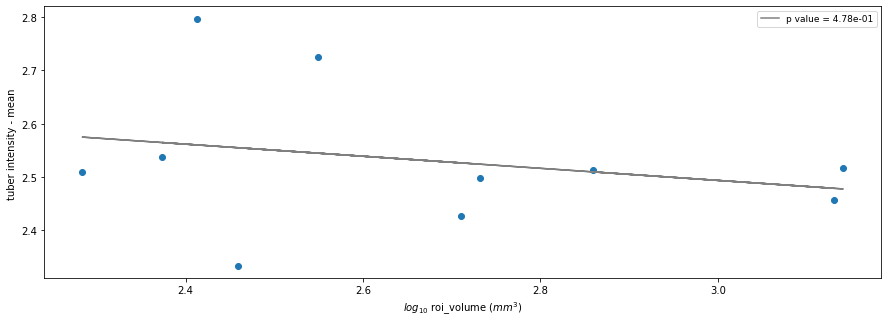

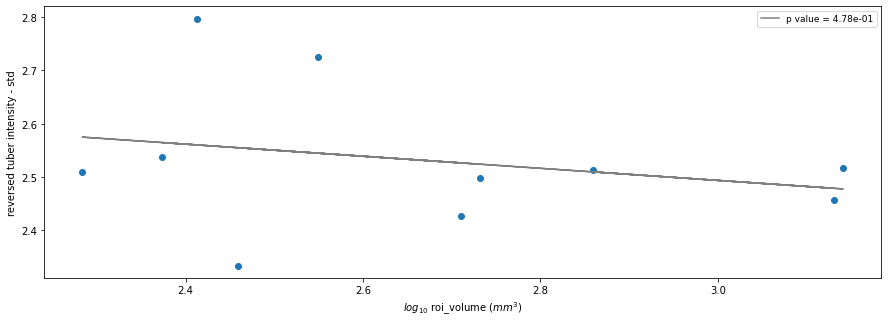

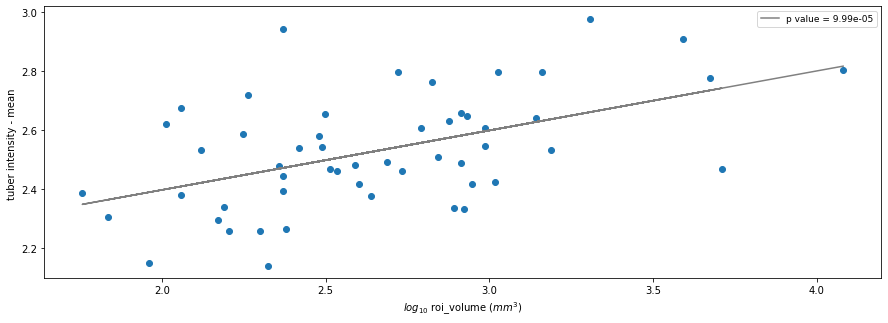

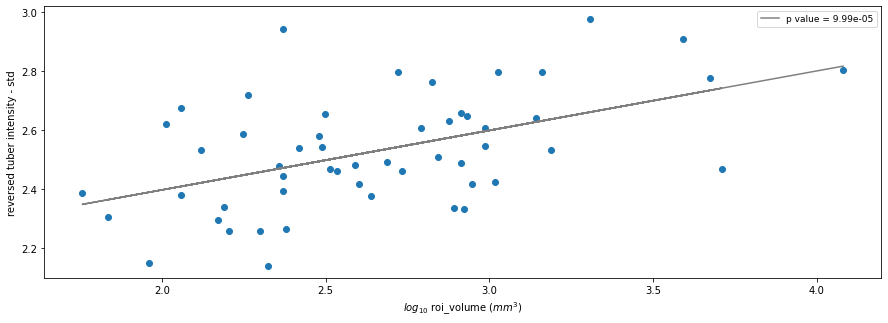

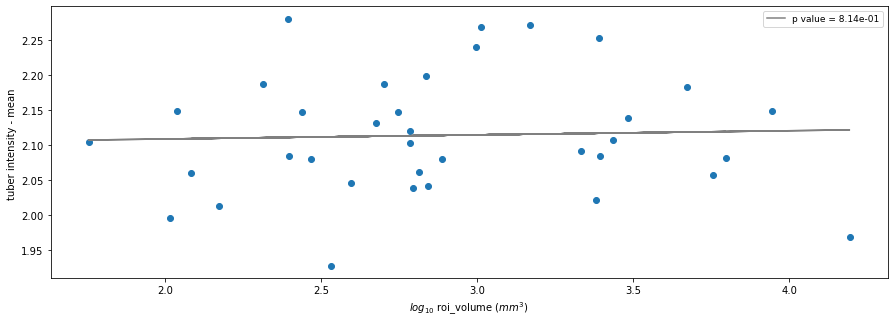

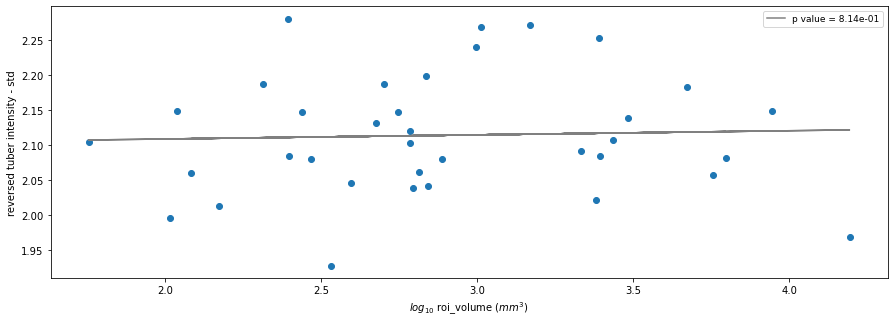

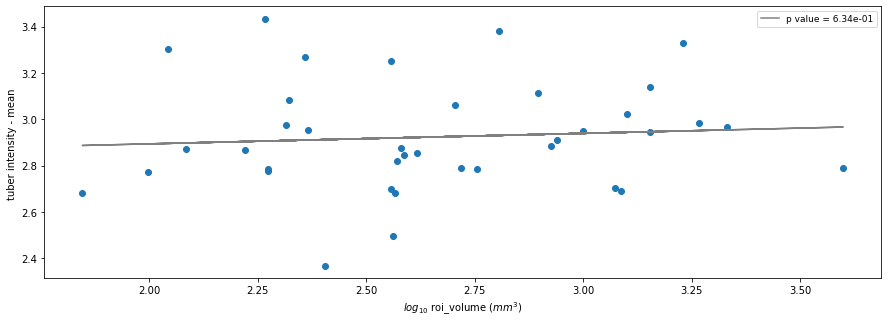

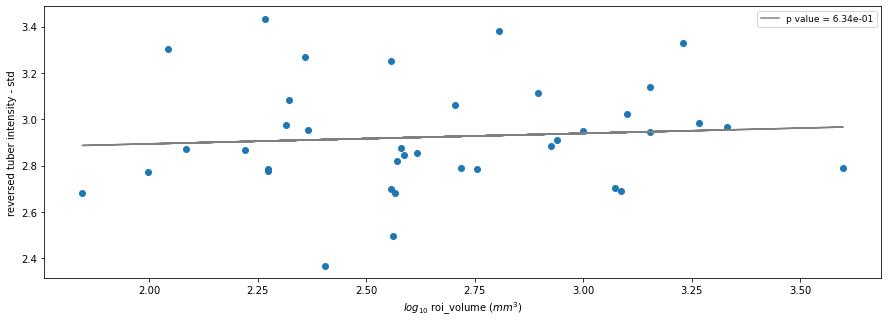

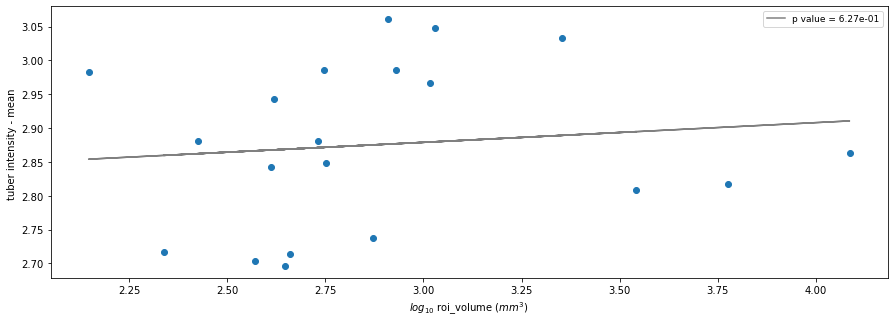

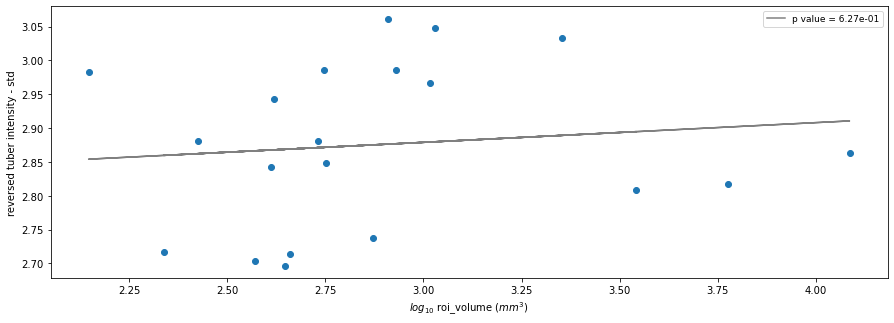

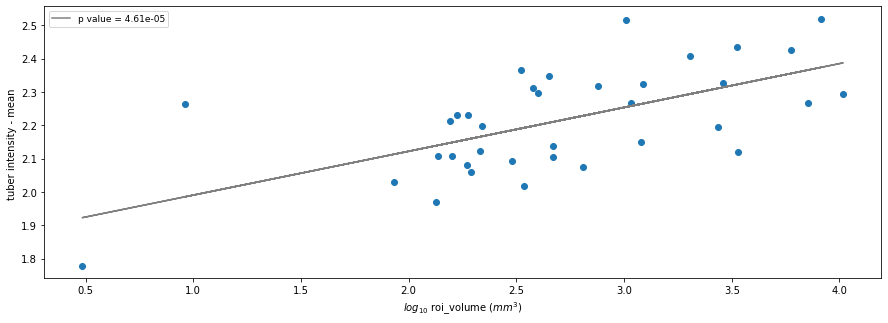

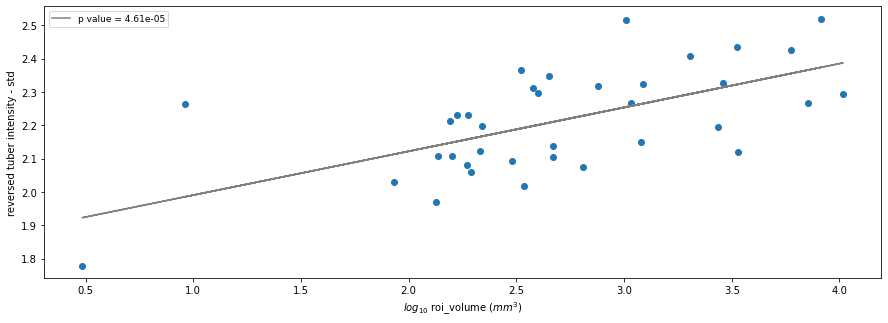

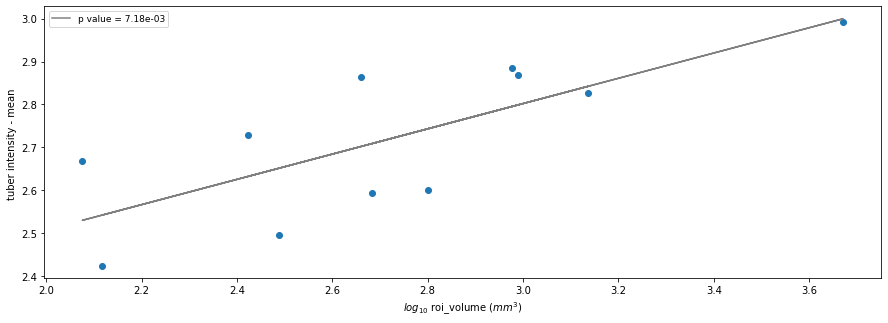

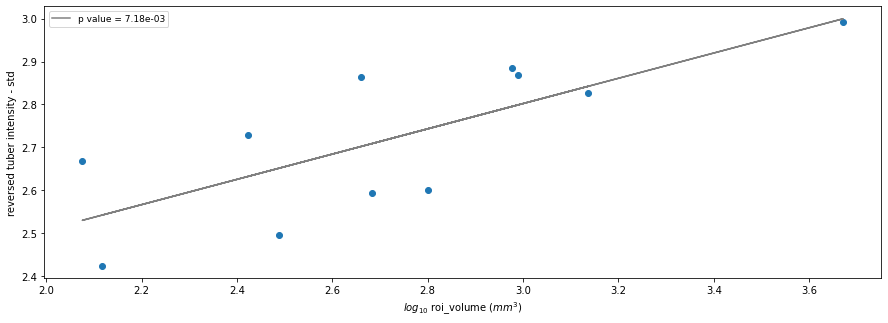

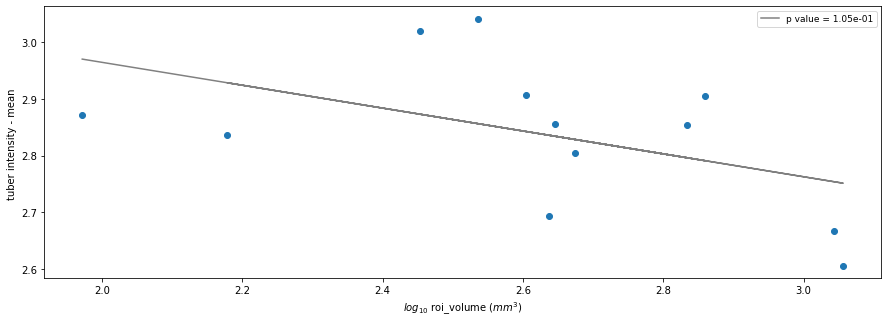

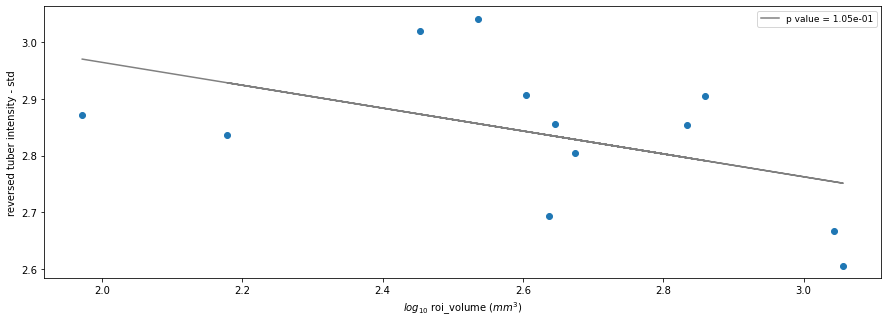

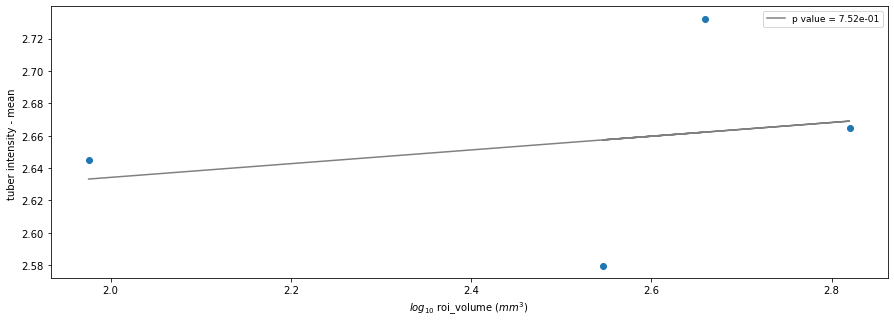

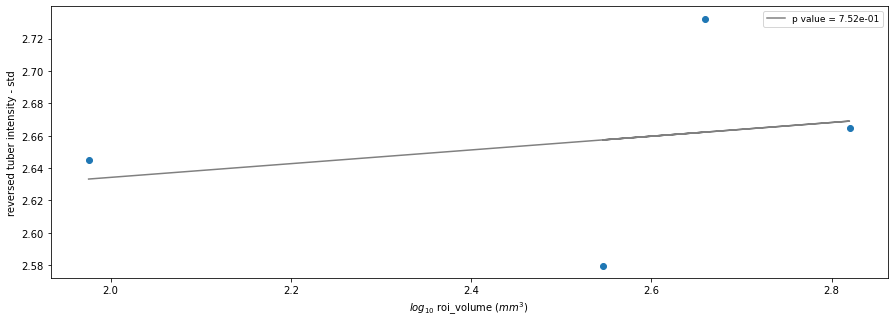

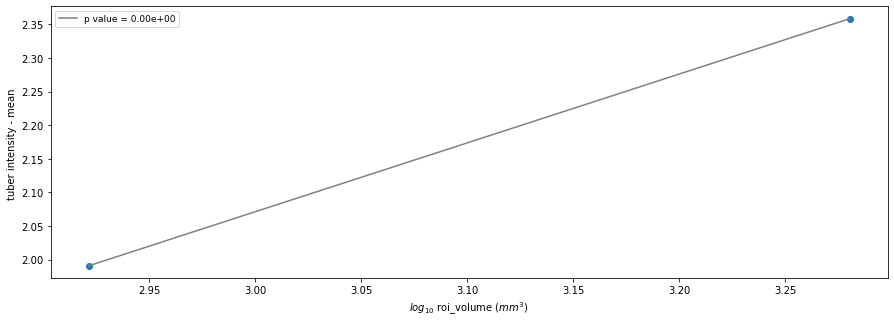

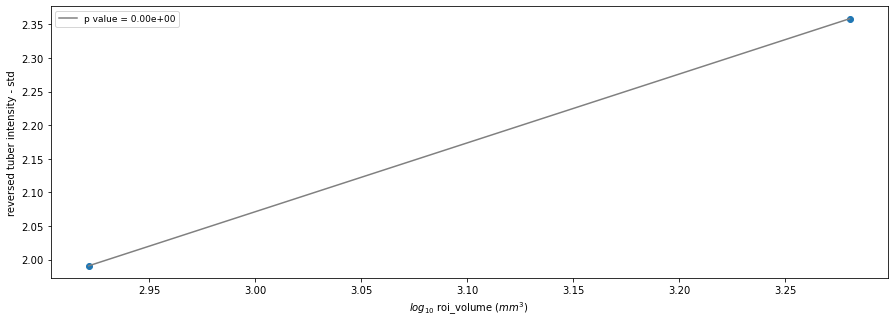

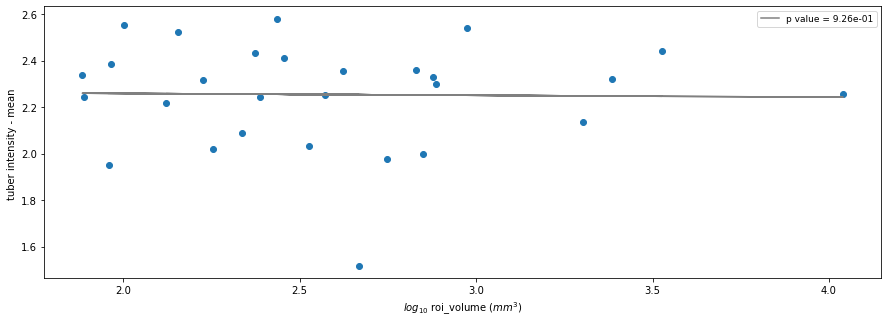

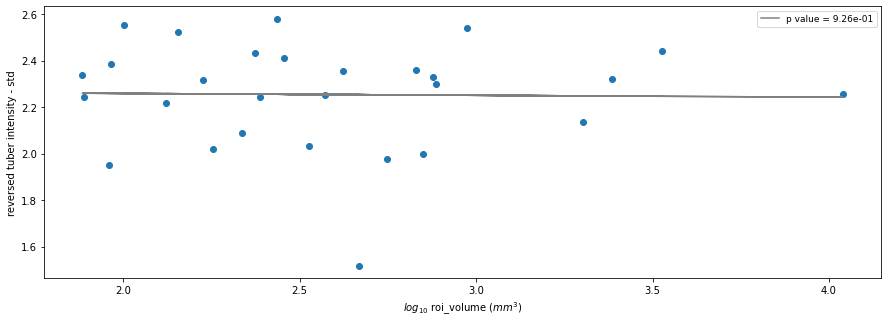

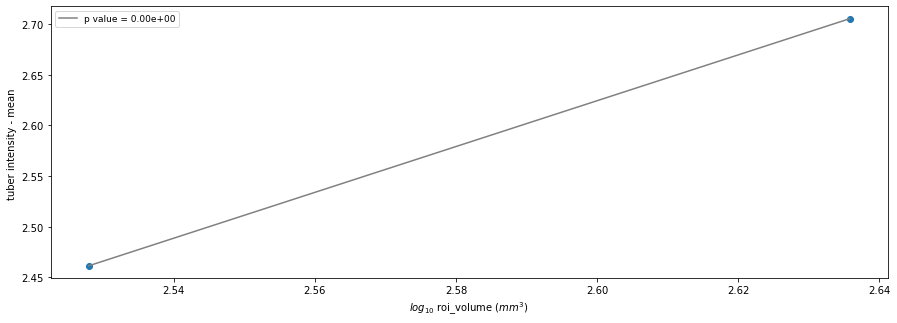

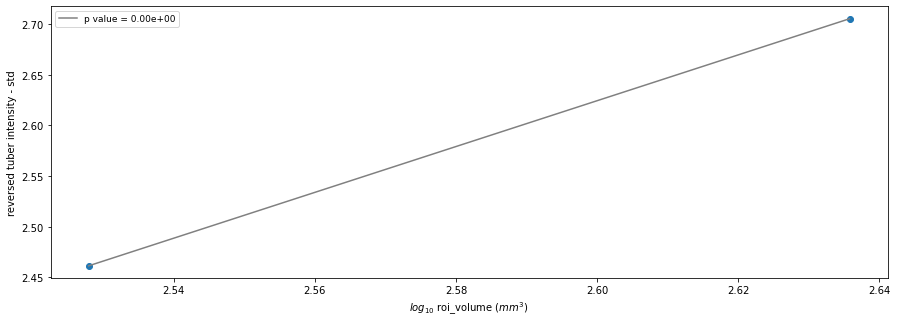

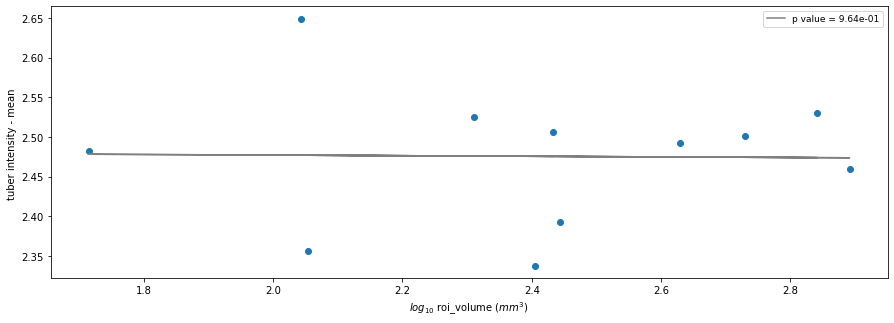

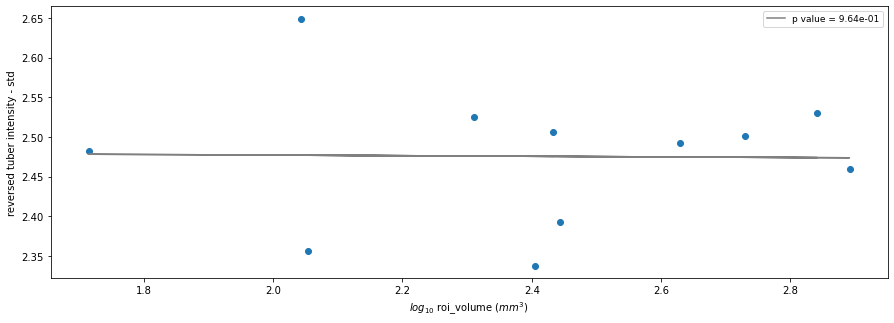

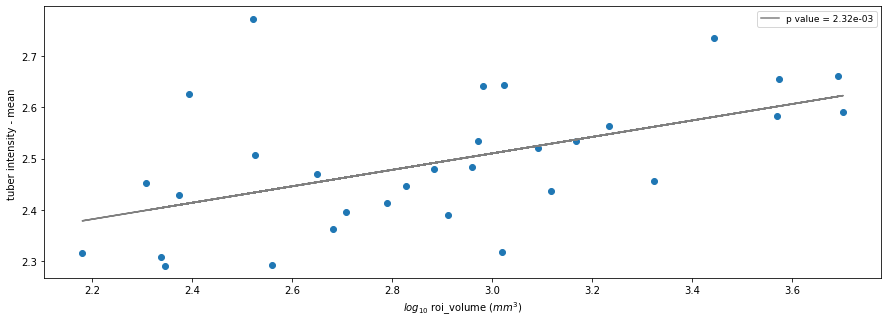

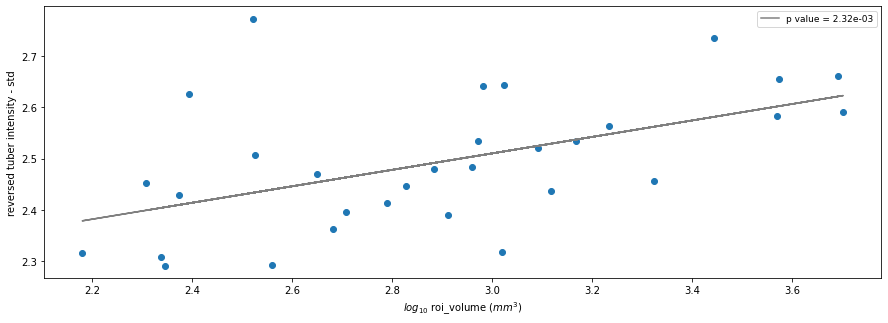

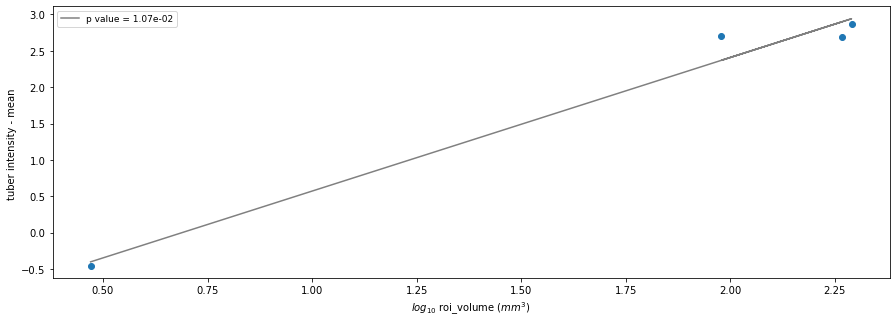

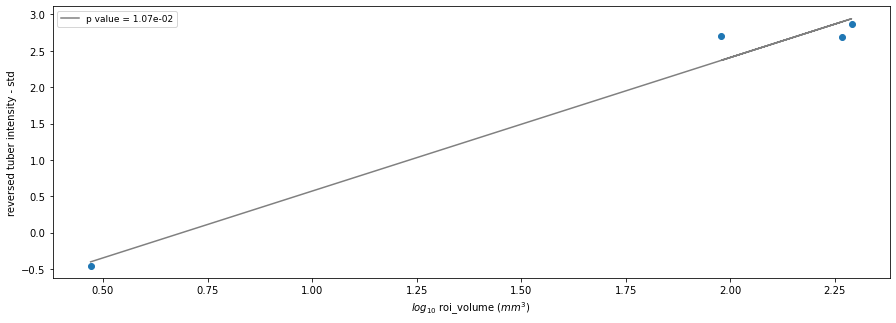

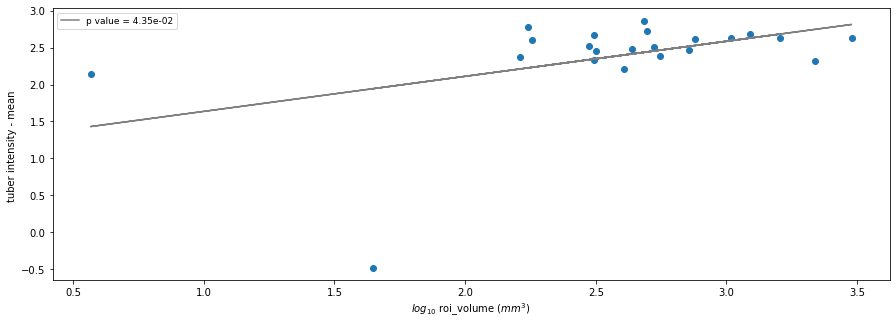

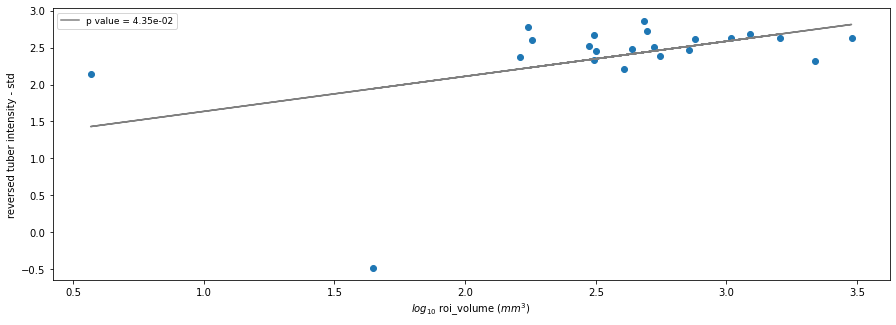

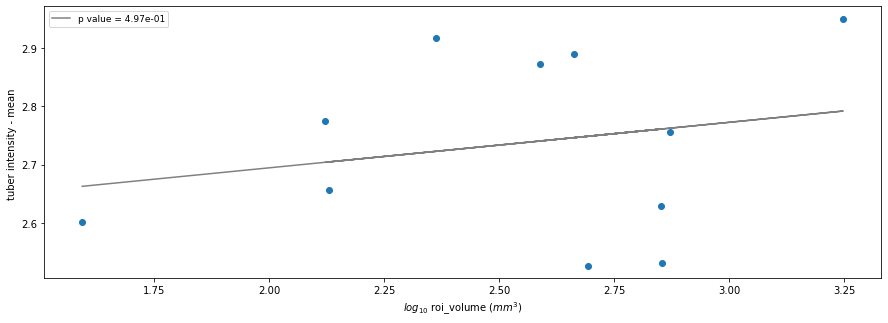

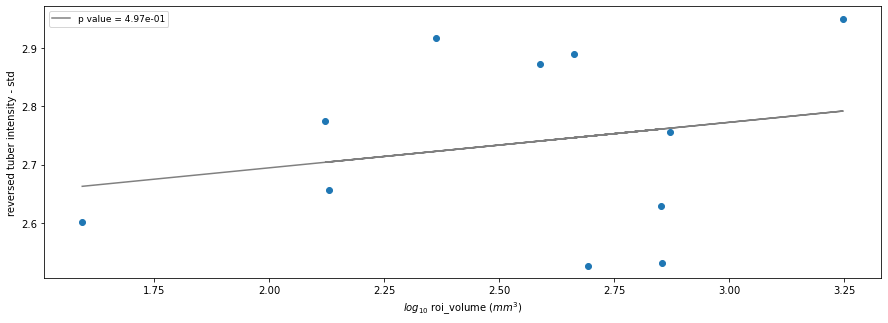

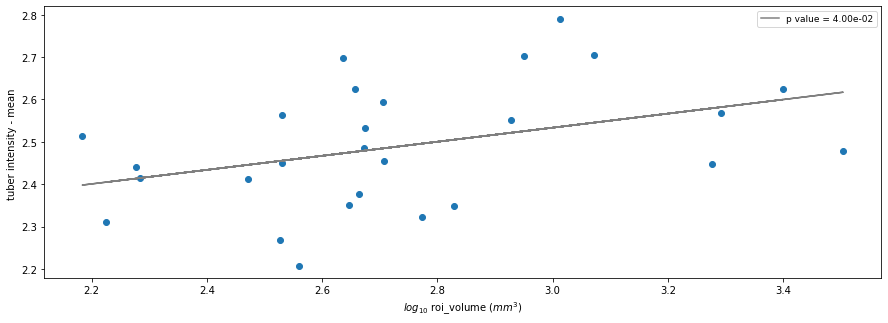

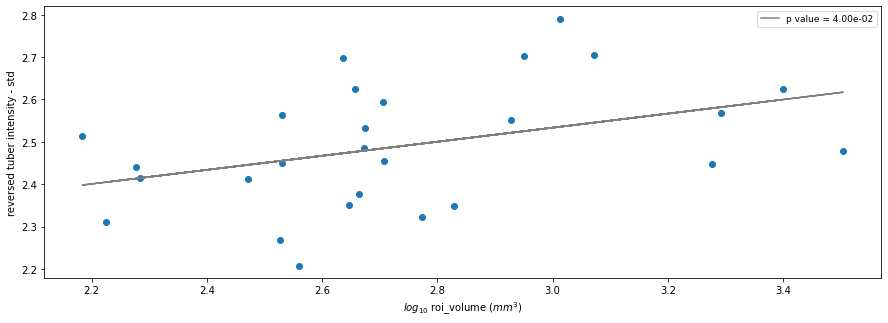

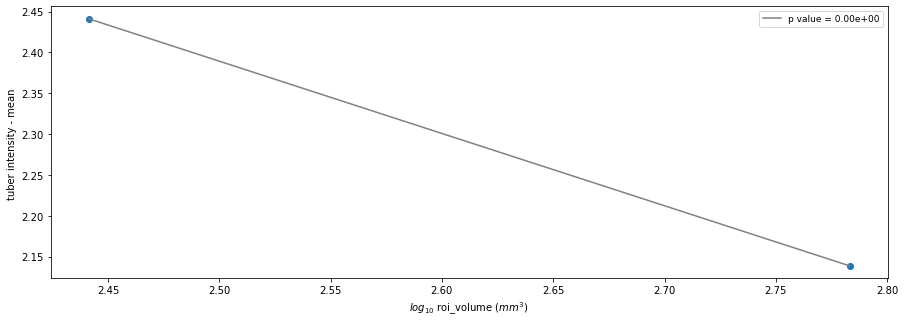

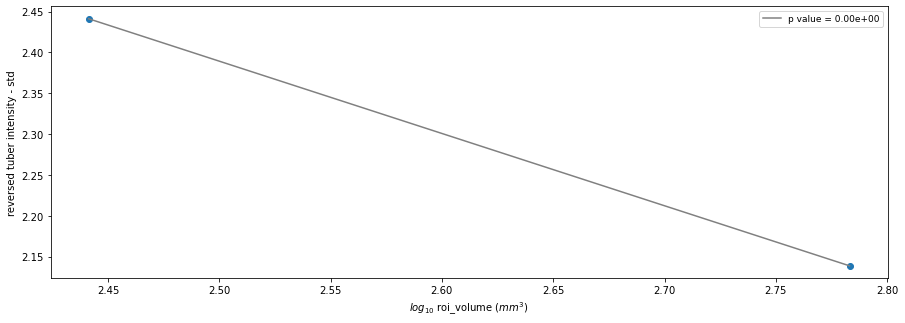

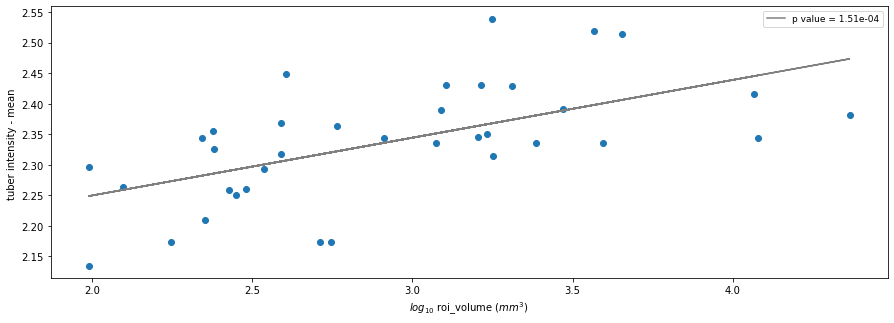

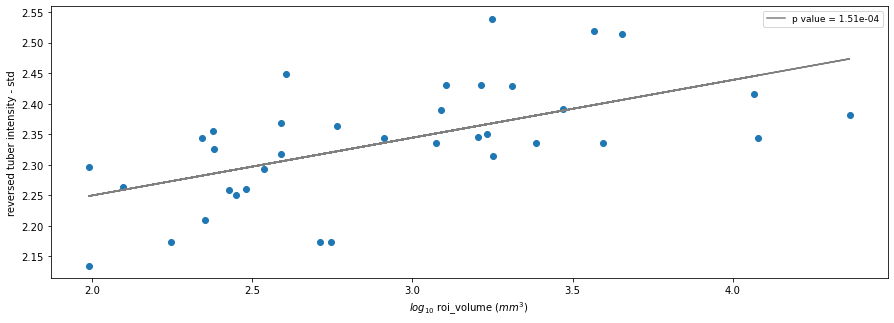

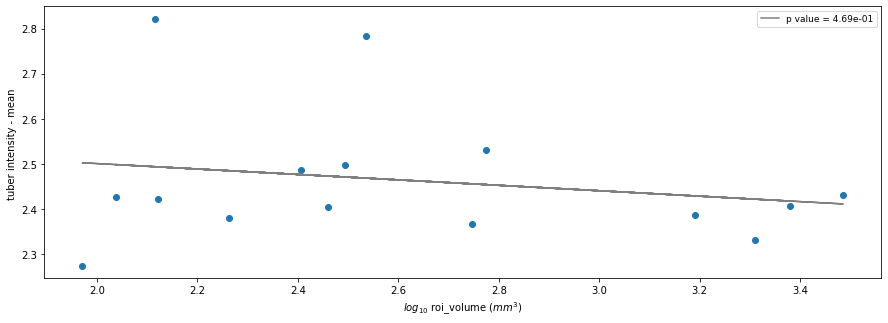

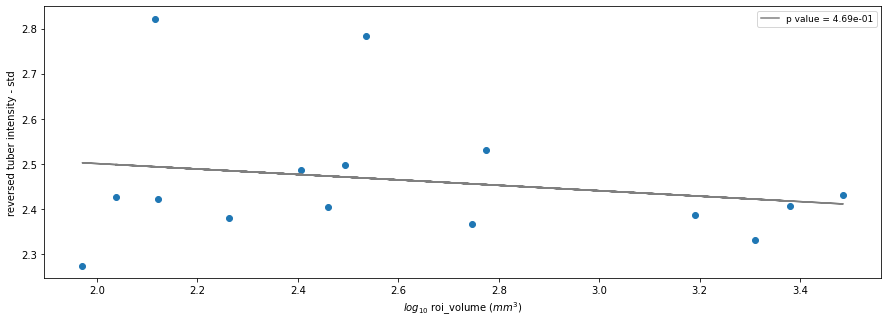

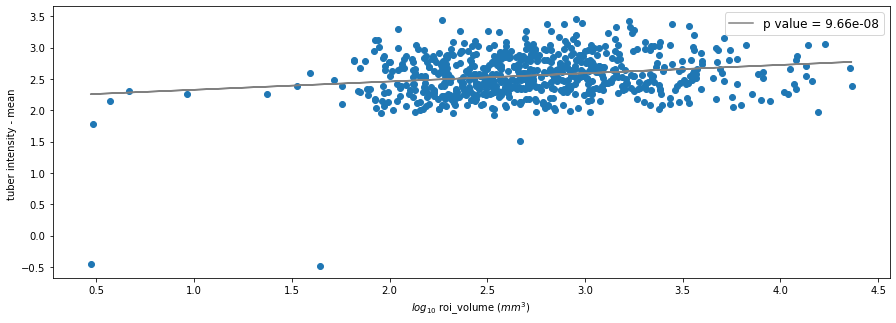

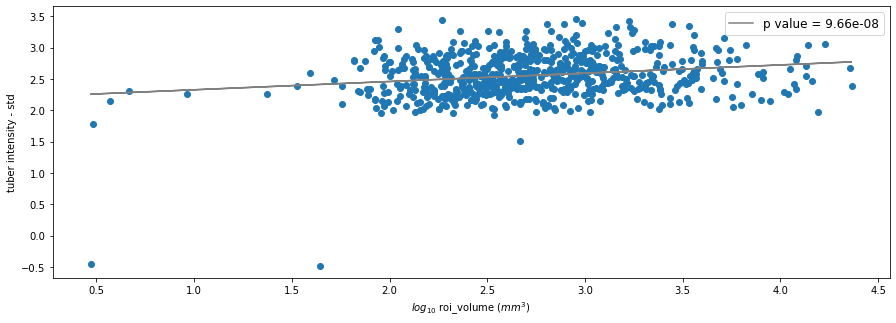

In [10]:
Analyzer.correlate_tuber_size_intensity(mod='all', group=True)

## 2. Voxel / Tuber distribution and threshold-based inference

0it [00:00, ?it/s]

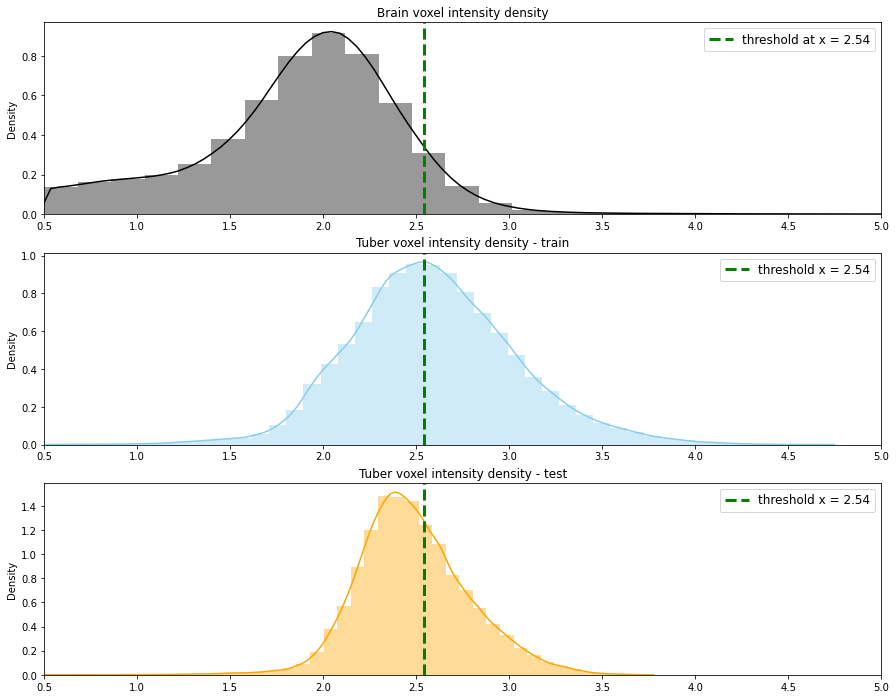

In [7]:
Analyzer.threhold_based_inference()

## 3. [Gross] number of tubers, volume of tubers, distribution of mean and intensity of tubers

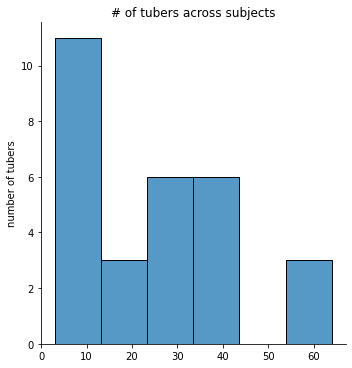

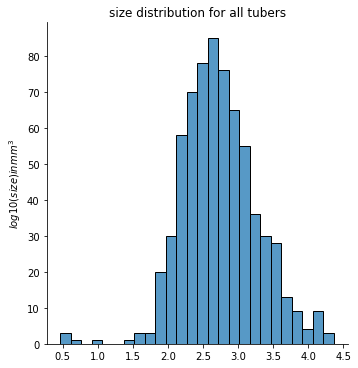

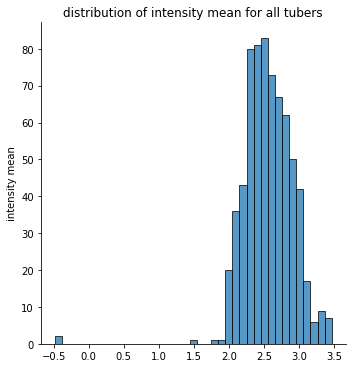

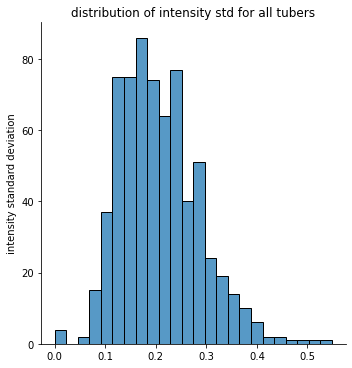

0

In [70]:
Analyzer.distribution_gross_tubers()

## 4. [Lobe] number of tubers, volume of tubers, distribution of mean and intensity of tubers

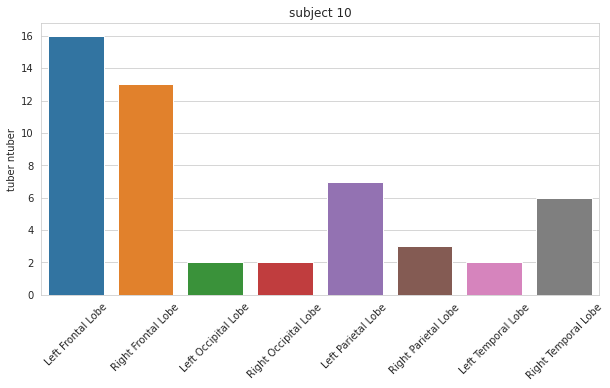

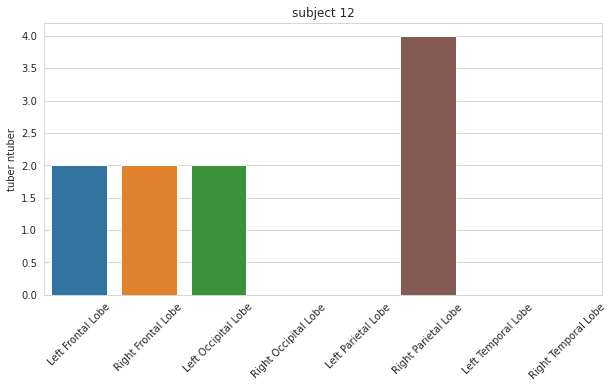

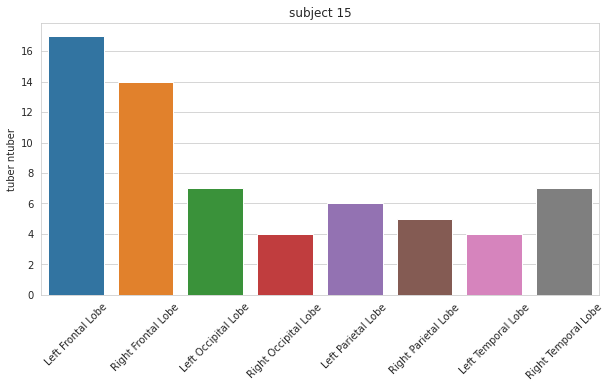

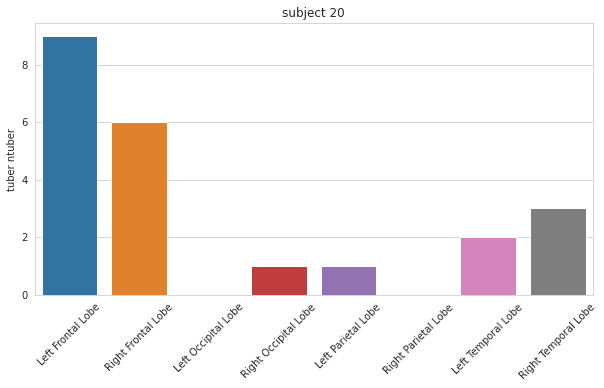

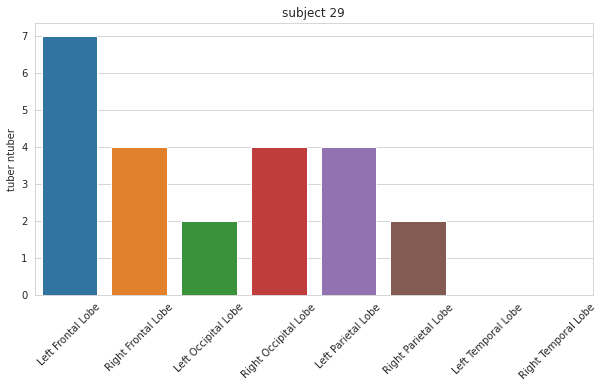

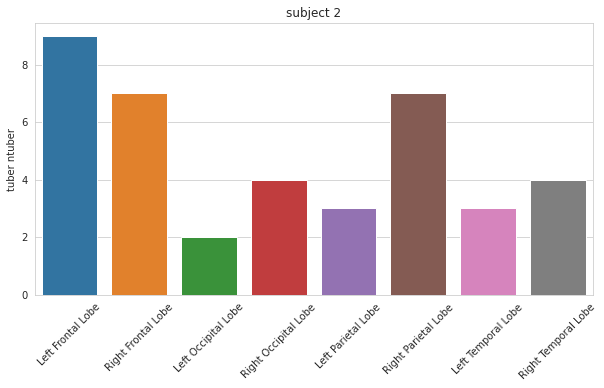

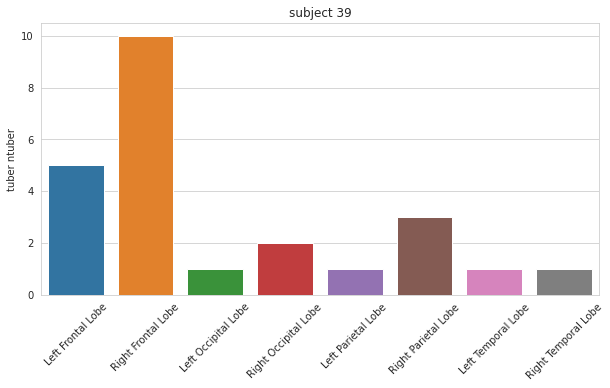

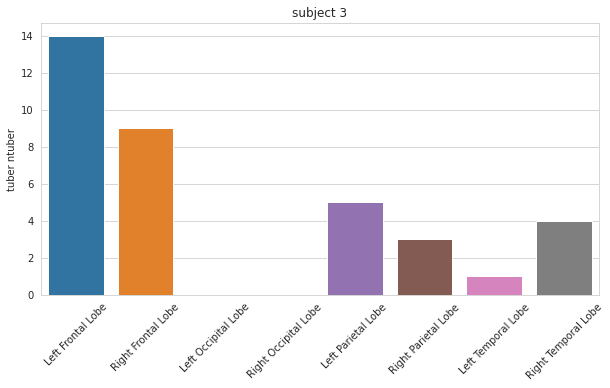

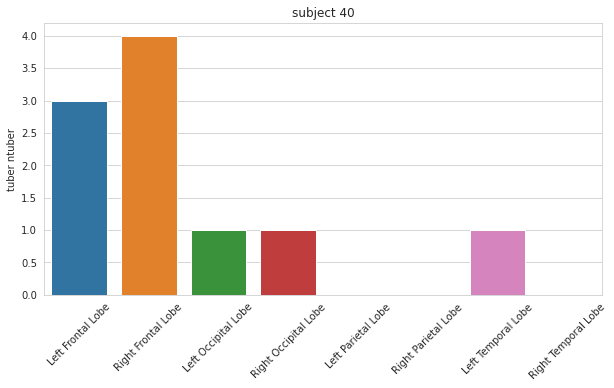

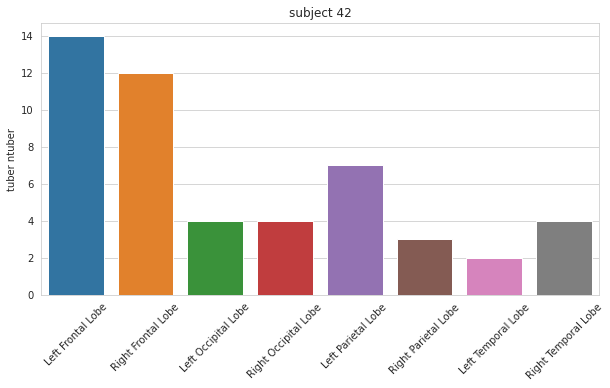

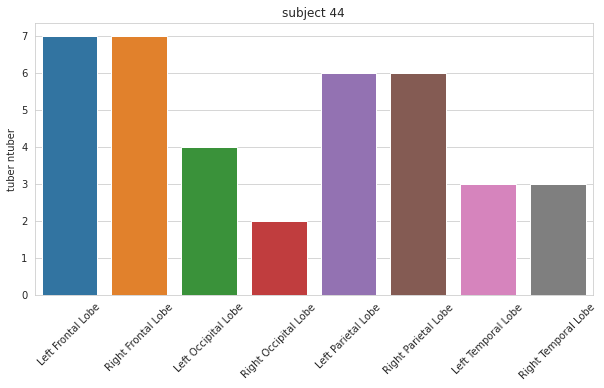

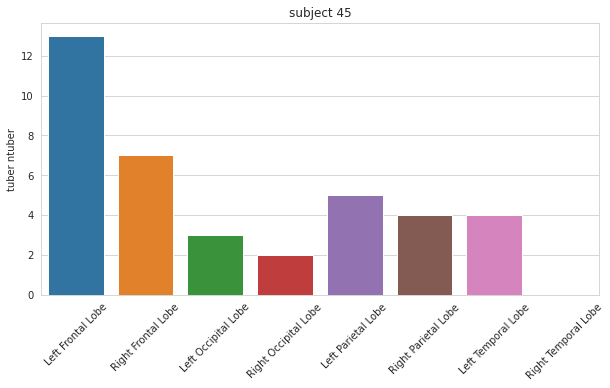

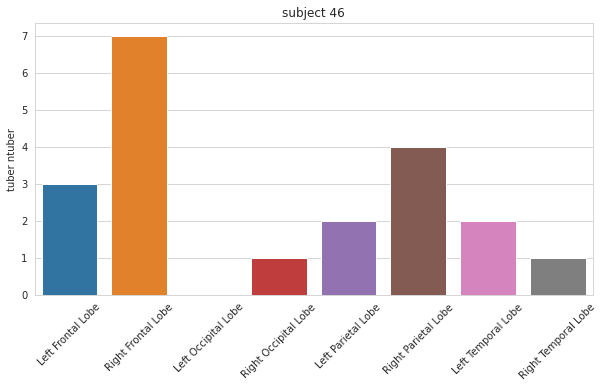

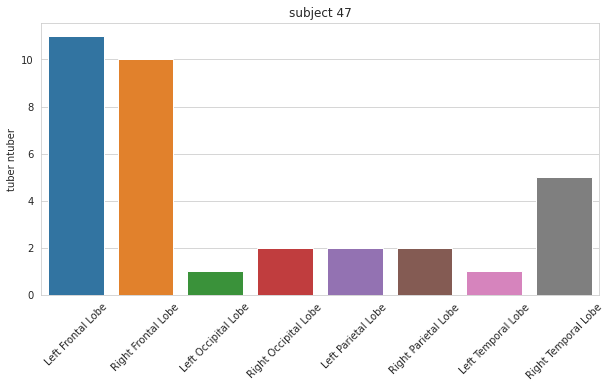

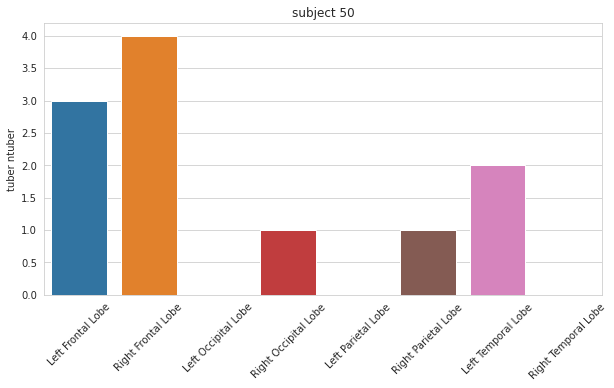

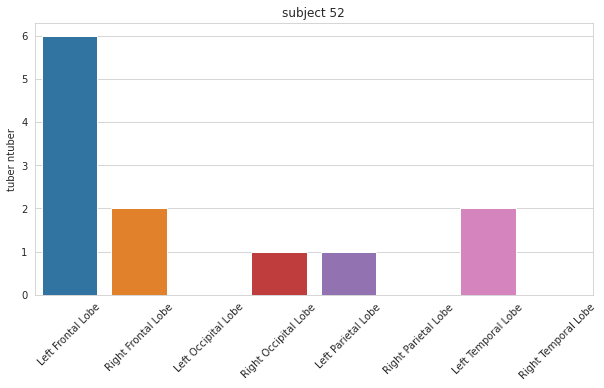

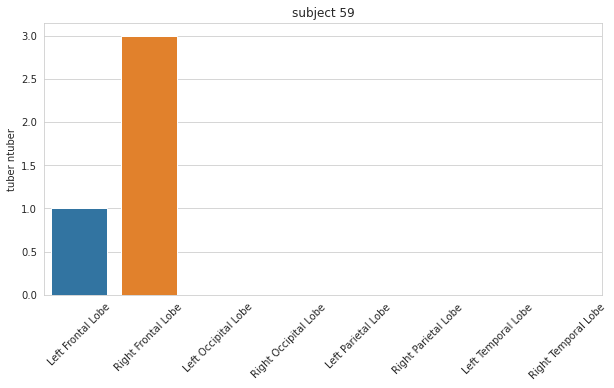

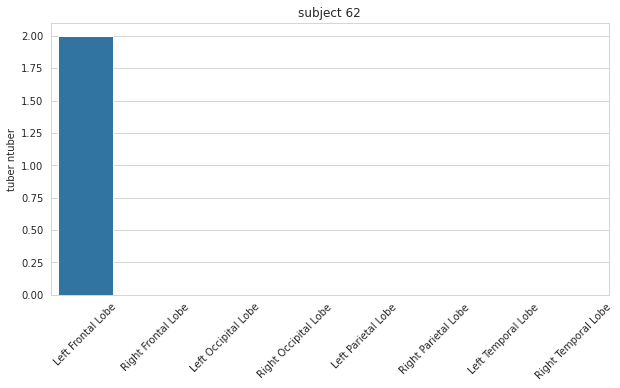

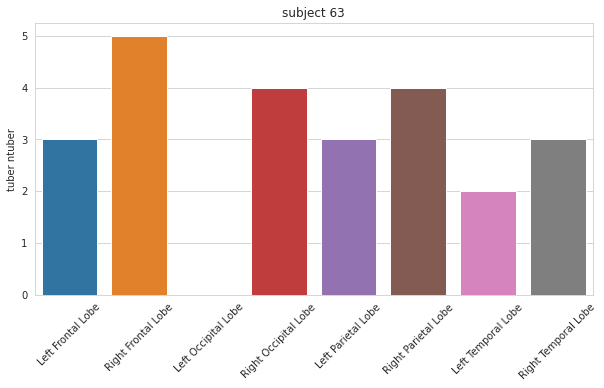

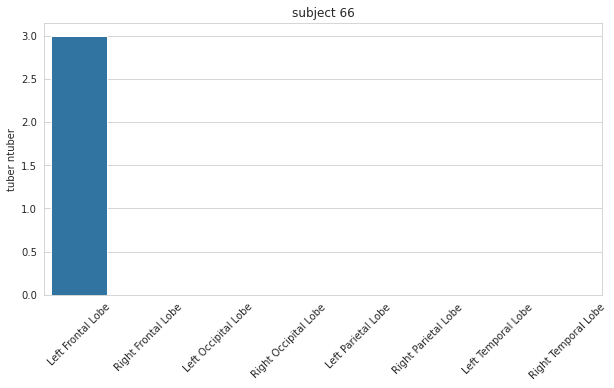

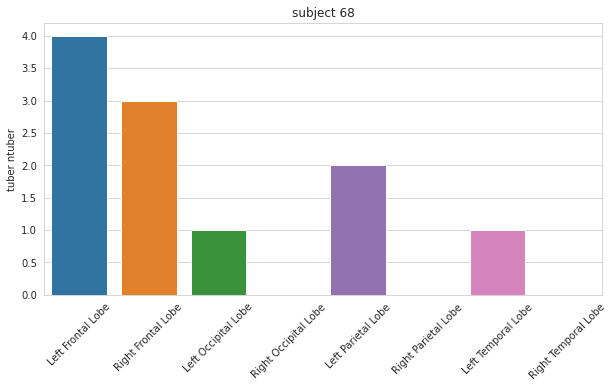

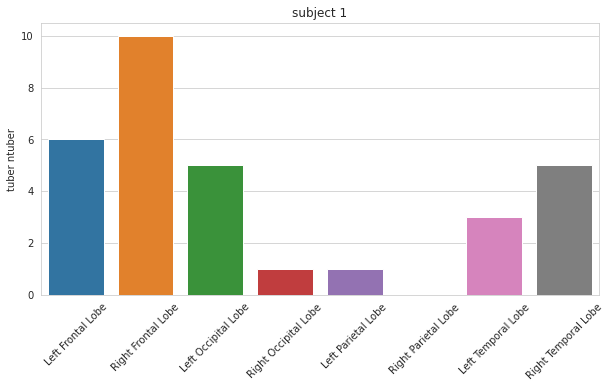

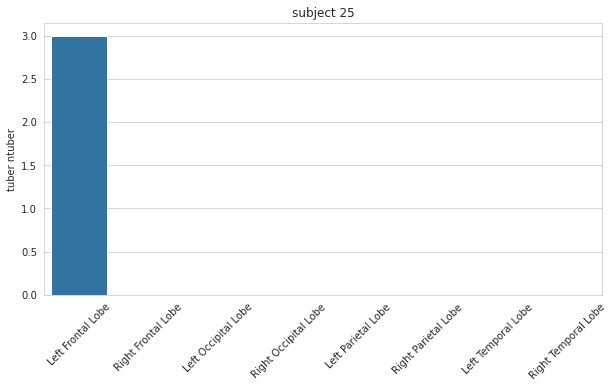

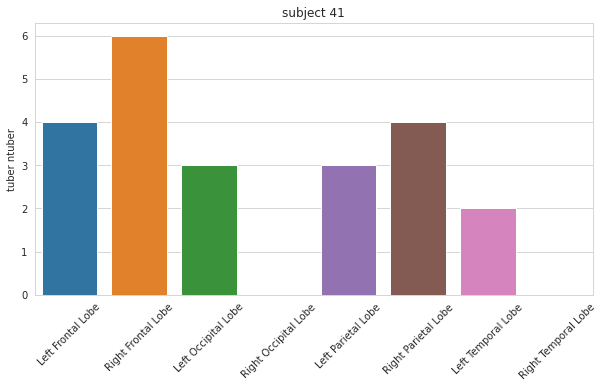

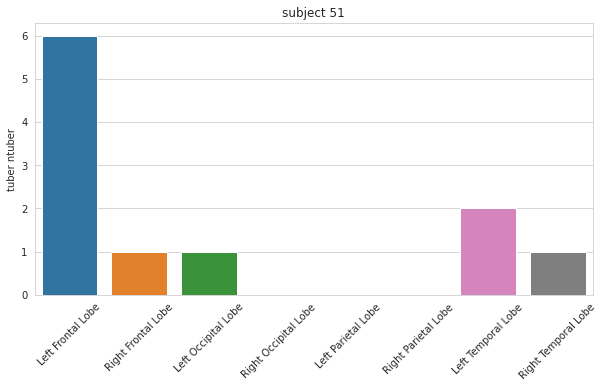

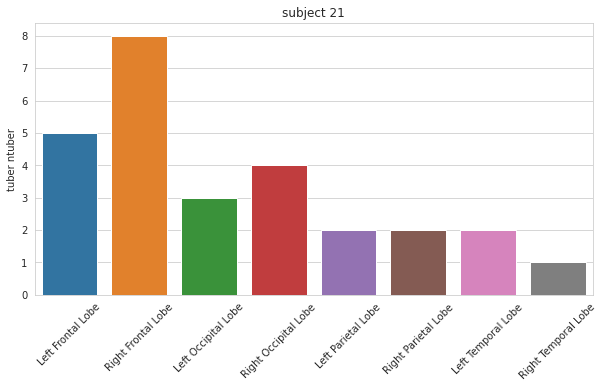

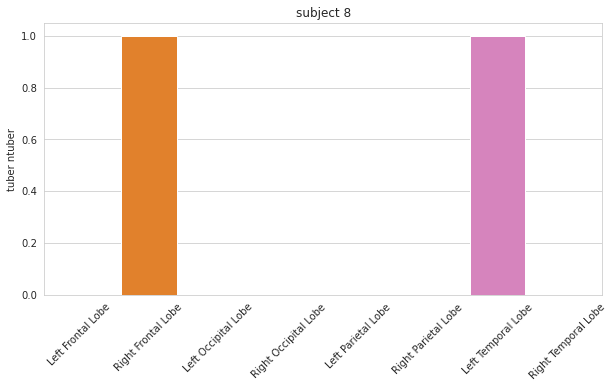

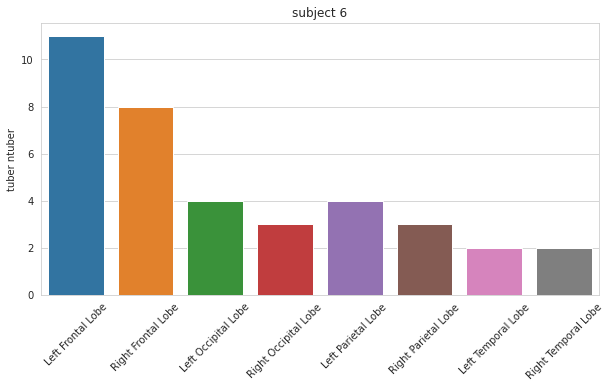

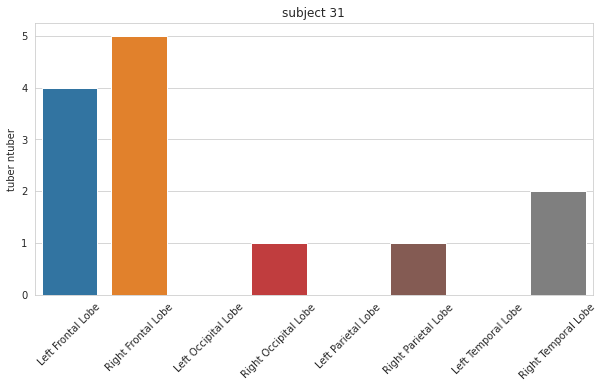

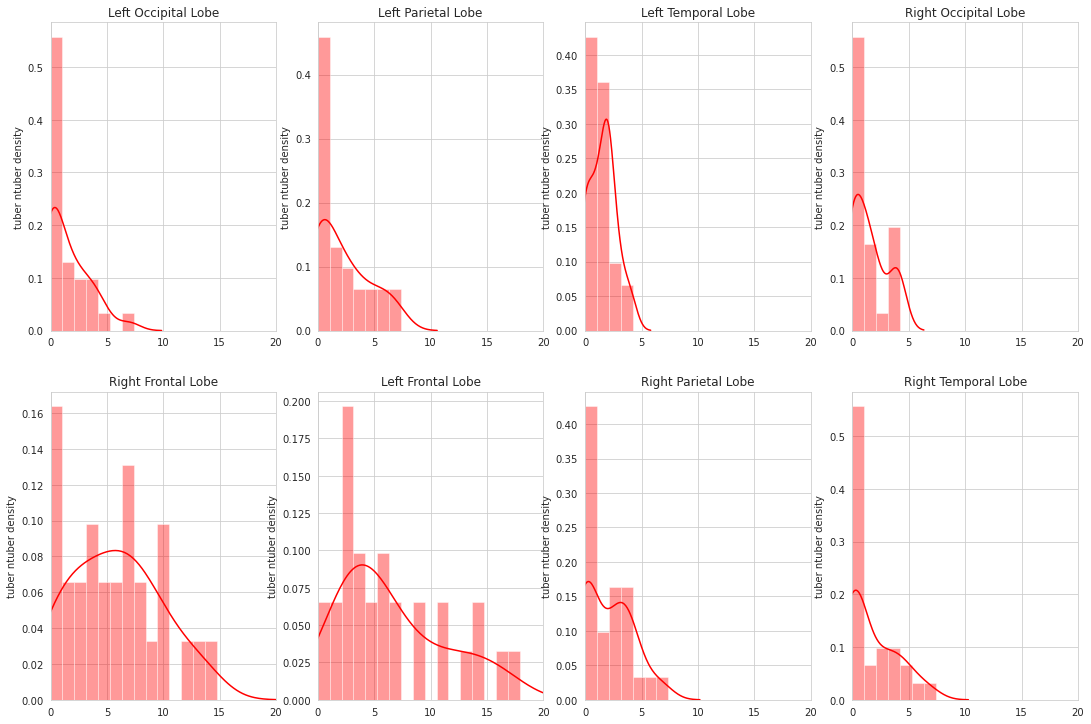

In [19]:
expkey = 'ntuber|mni|vnormFalse|znormFalse|mask_FL_reg2tp_thr0.5' # ntuber, area, intensity
lobe_level_indiv_stats = EXP.tuber_stats[expkey]
varsub = 'mean'
# lobe_level_indiv_stats = EXP.tuber_stats[expkey][varsub]
Analyzer.distribution_lobe_tubers(lobe_level_indiv_stats, var = expkey.split("|")[0], var_sub = varsub)

## 5. Report statistical model results

                                                  
pred_reg2tp_thr0.5 area False True
##################################################


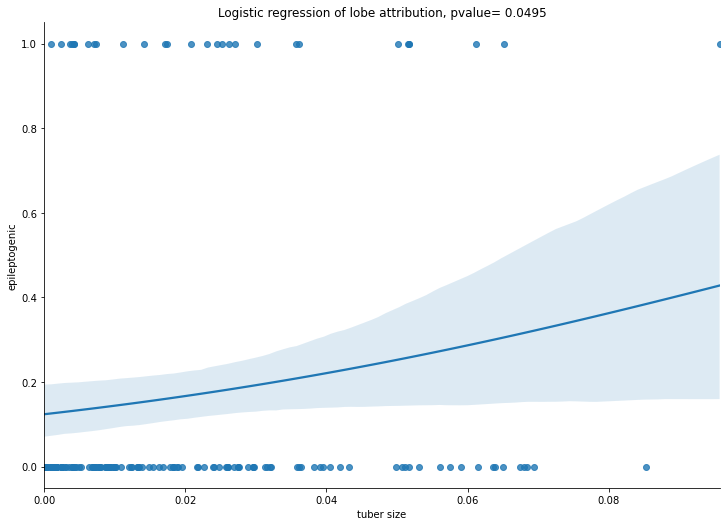

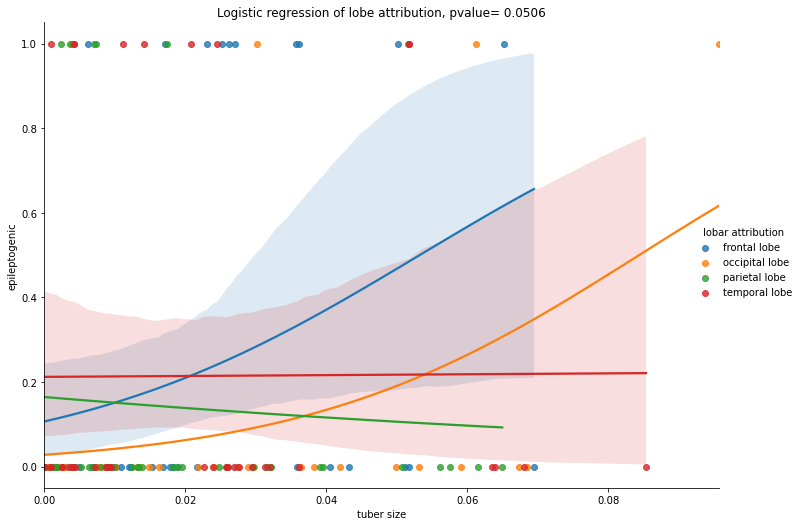

2.7752028875924704 0.050601965295962704
                                                  
pred_reg2tp_thr0.5 ntuber False True
##################################################


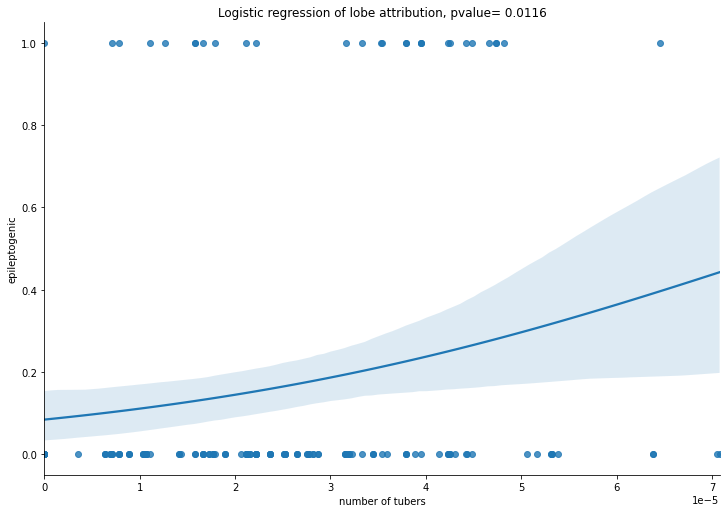

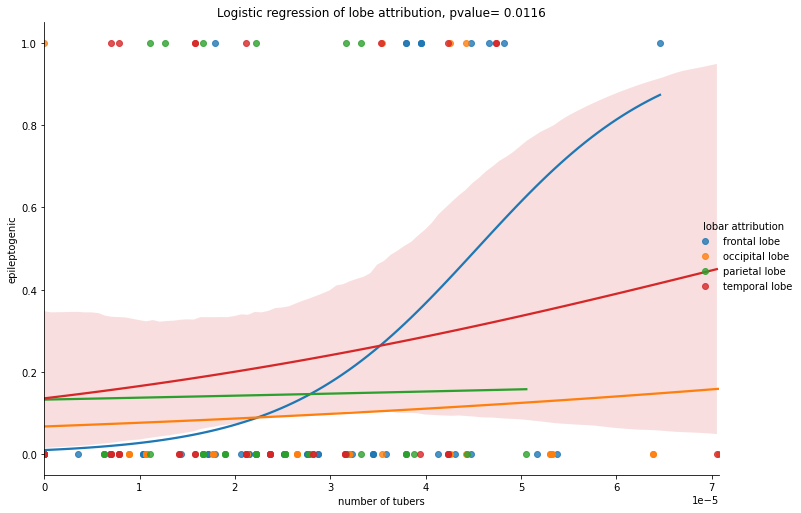

4573.063481833671 0.0115759049139367
                                                  
pred_reg2tp_thr0.5 intensity False True
##################################################


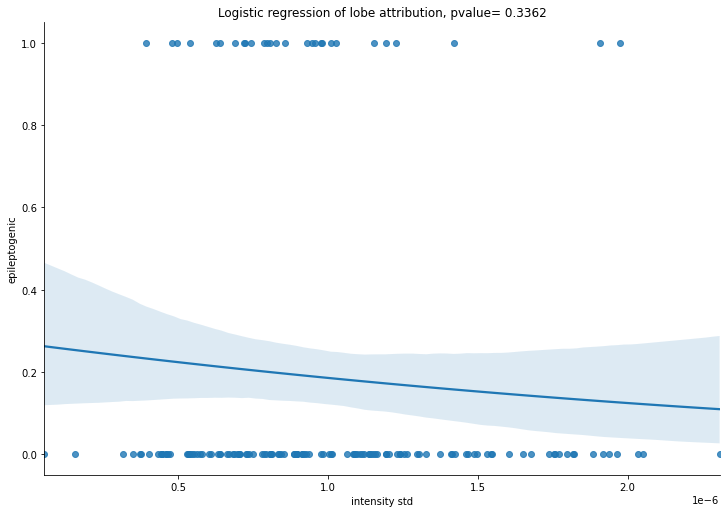

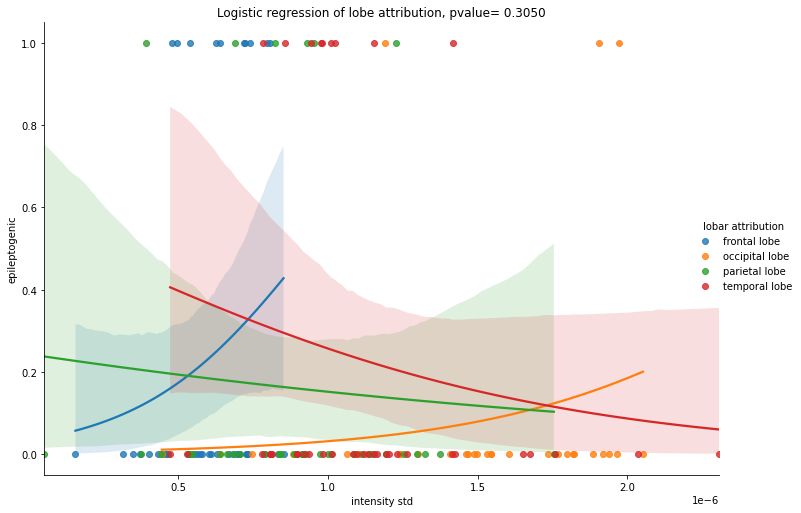

-78226.98320318037 0.305039939916818
                                                  
mask_FL_reg2tp_thr0.5 area False True
##################################################


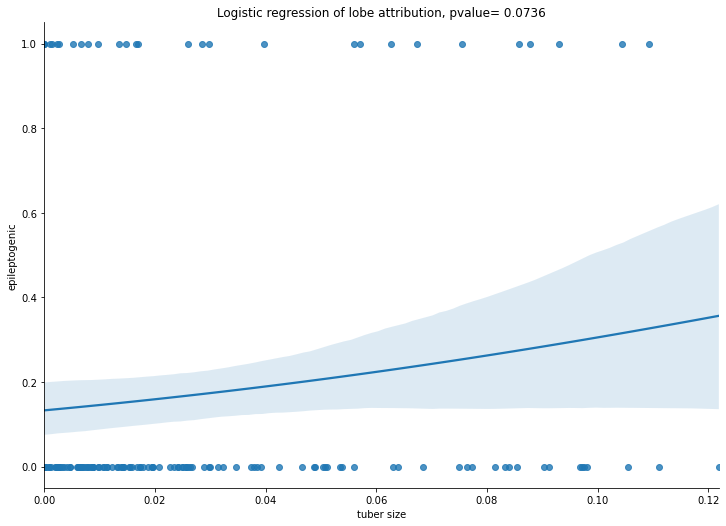

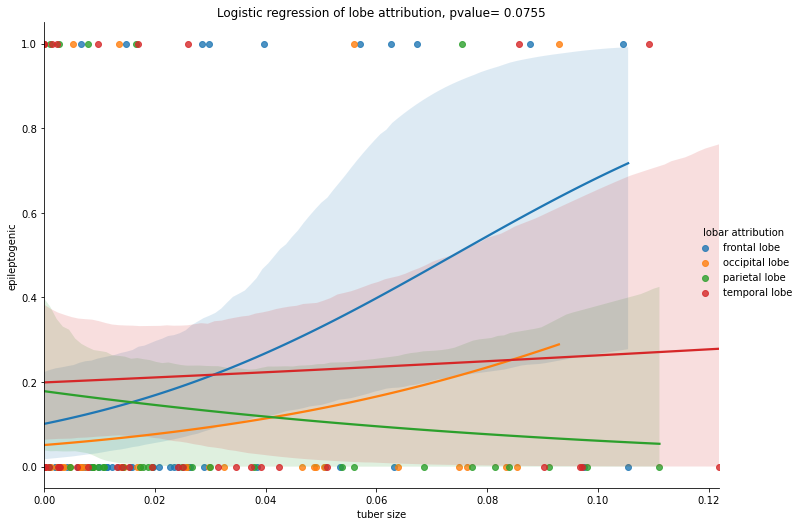

1.6812668994497972 0.07546725958317542
                                                  
mask_FL_reg2tp_thr0.5 ntuber False True
##################################################


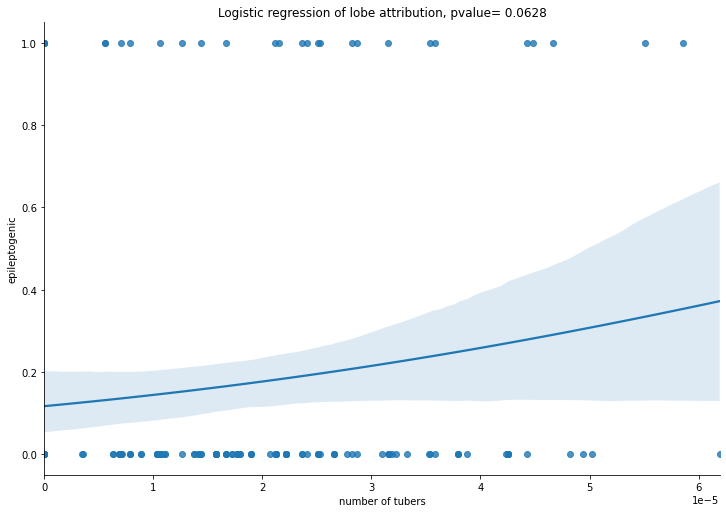

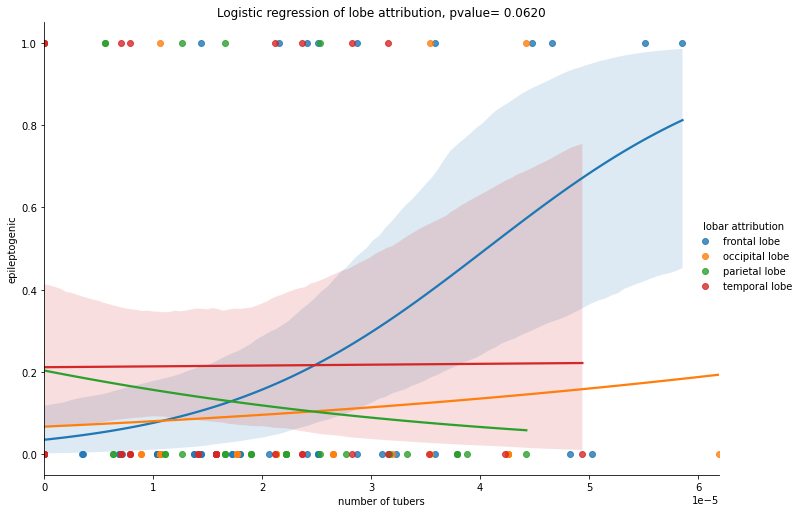

3778.8468404621567 0.06201821875311718
                                                  
mask_FL_reg2tp_thr0.5 intensity False True
##################################################


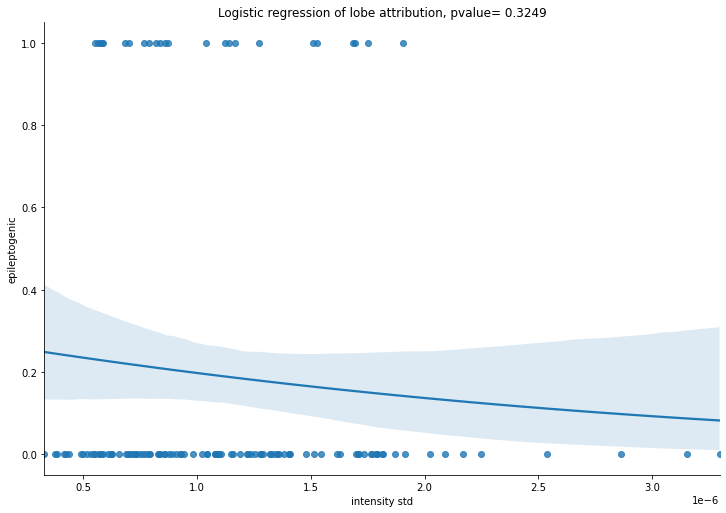

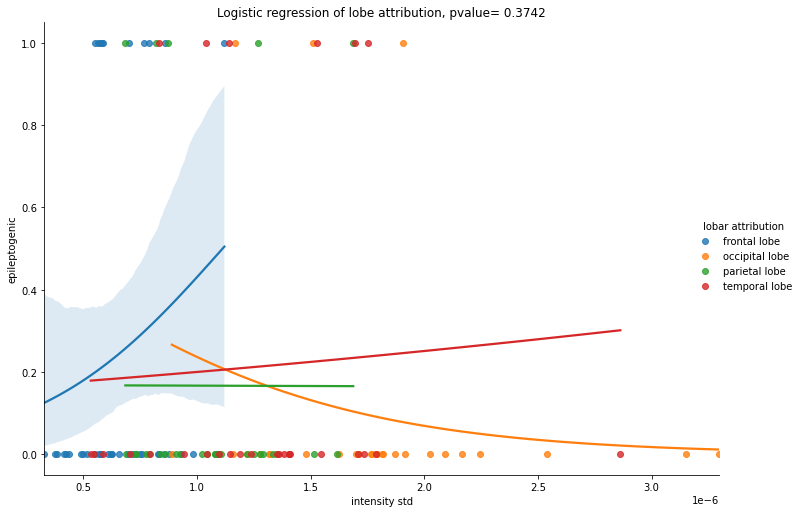

-59846.24816534885 0.37421747565835517
                                                  
mask_FL_cystic_reg2tp_thr0.5 area False True
##################################################


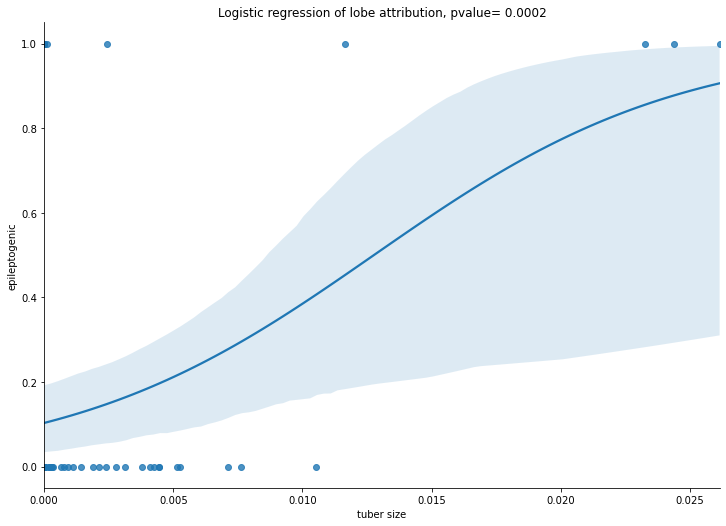

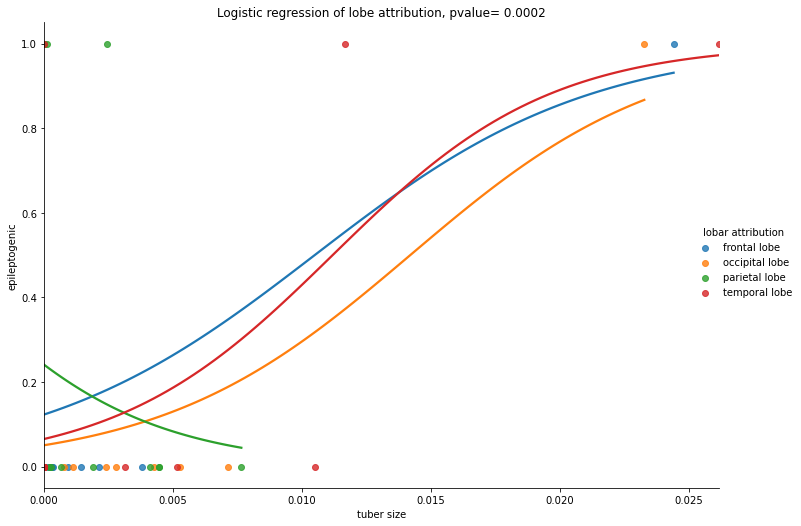

30.93695525699615 0.00020933319347282128
                                                  
mask_FL_cystic_reg2tp_thr0.5 ntuber False True
##################################################


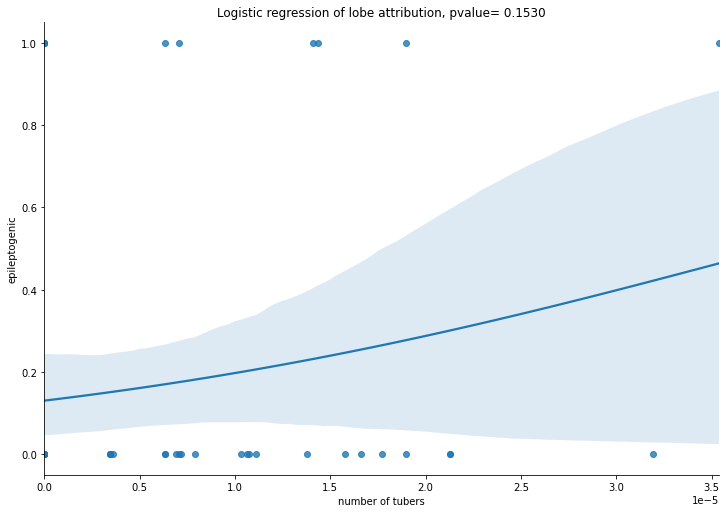

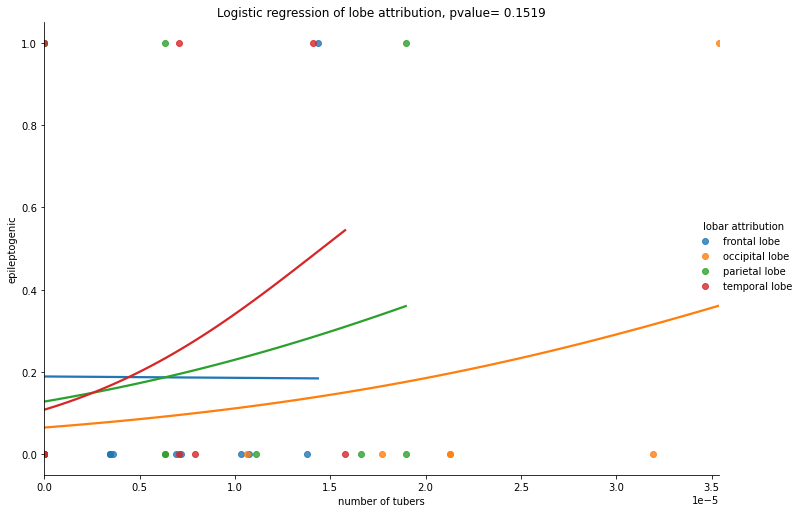

8462.741049490849 0.15187953908172816
                                                  
mask_FL_cystic_reg2tp_thr0.5 intensity False True
##################################################


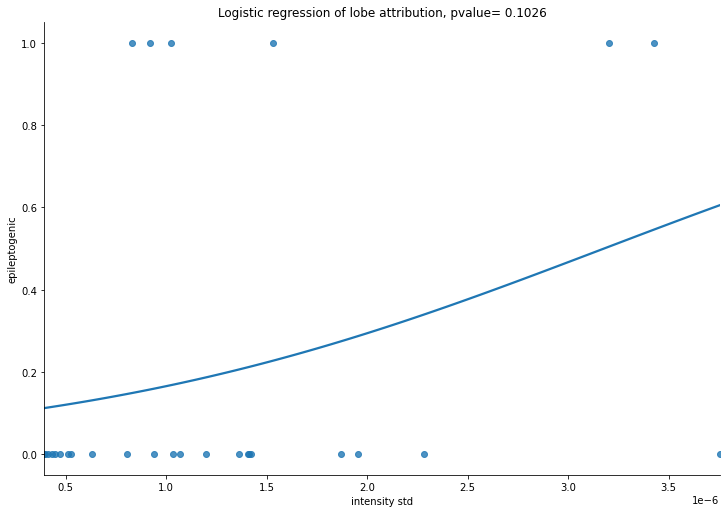

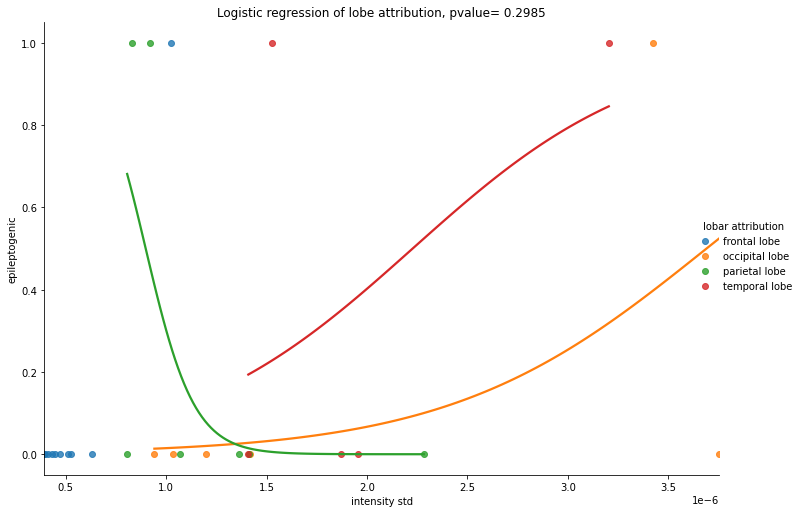

108415.98774295385 0.2985189976695378
                                                  
mask_FL_cysadded_reg2tp_thr0.5 area False True
##################################################


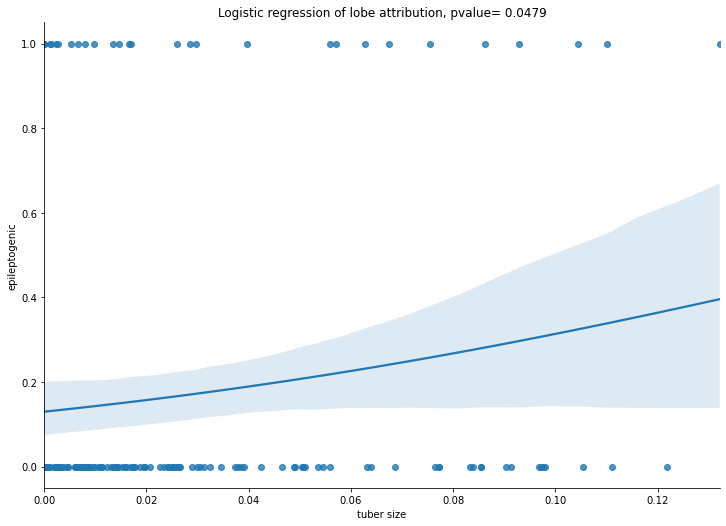

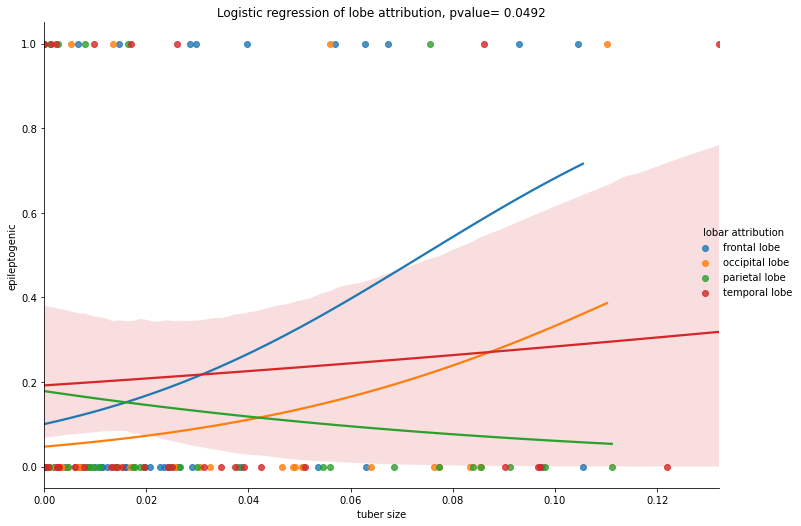

1.8113828982475737 0.0492122358751227
                                                  
mask_FL_cysadded_reg2tp_thr0.5 ntuber False True
##################################################


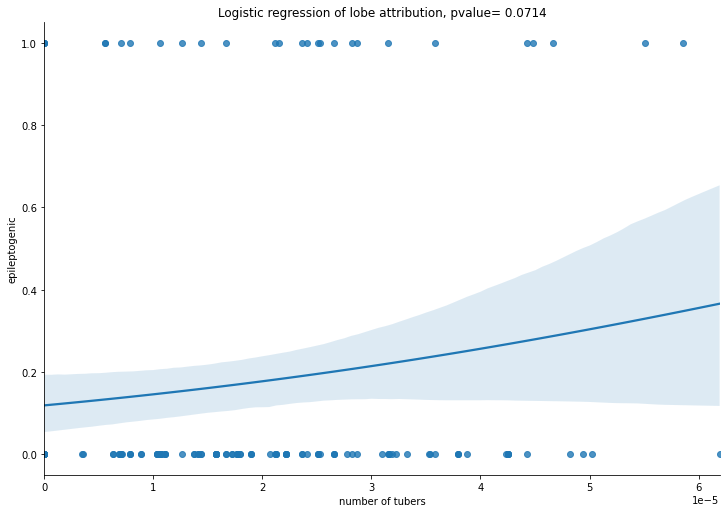

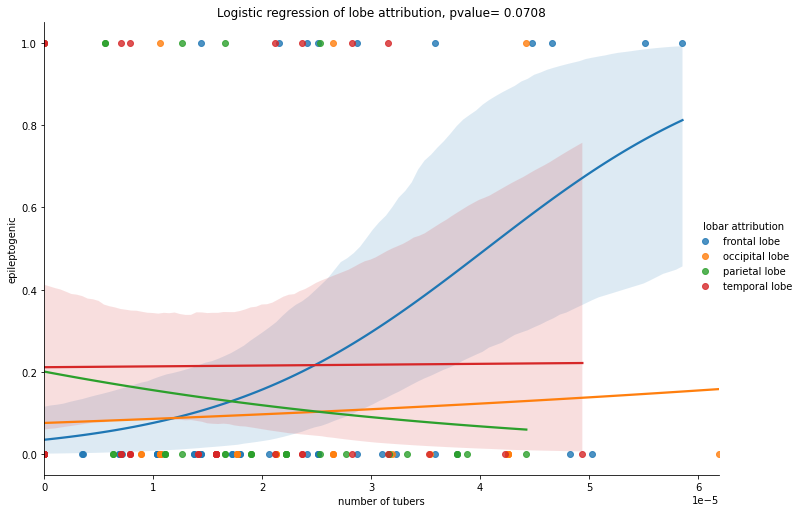

3668.00522851255 0.0708291674651094
                                                  
mask_FL_cysadded_reg2tp_thr0.5 intensity False True
##################################################


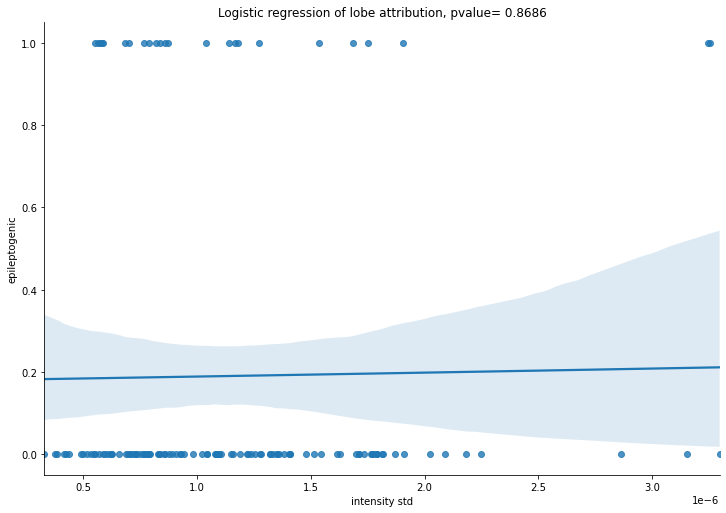

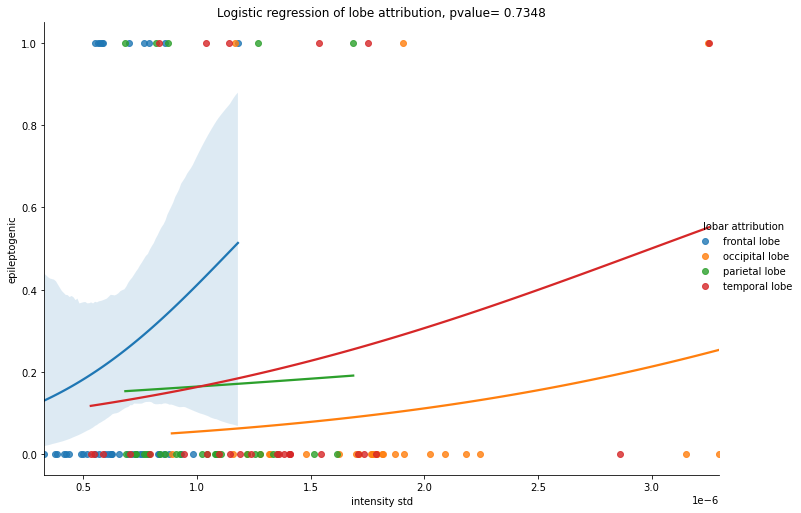

21072.361435333318 0.7348259528345145


In [10]:
lobes = ['5', '6', '9', '10', '11', '12', '15', '16'] 
for mod in ['pred_reg2tp_thr0.5', 'mask_FL_reg2tp_thr0.5', 'mask_FL_cystic_reg2tp_thr0.5', 'mask_FL_cysadded_reg2tp_thr0.5']:
    for var in ['area', 'ntuber', 'intensity']:
        for znorm in [False]:
            for vnorm in [True]:
                print(' '*50)
                print(mod, var, znorm, vnorm)
                print('#'*50)
#                 print(' '*50)
                coef, pvalue= EXP.get_logistic_regress(lobes, 
                                                       var_='{}|mni|vnorm{}|znorm{}|{}'.format(var,vnorm, znorm, mod),
                                                       control_lobe=False, 
                                                       merge_lr = False,
                                                       show_img = True, 
                                                       save_img = True,
                                                      )
    
                coef, pvalue= EXP.get_logistic_regress(lobes, 
                                                       var_='{}|mni|vnorm{}|znorm{}|{}'.format(var,vnorm, znorm, mod),
                                                       control_lobe=True,
                                                       merge_lr = True,
                                                       show_img = True, 
                                                       save_img=True,
                                                      )
                print(coef, pvalue)

## 6. Individual tuber display

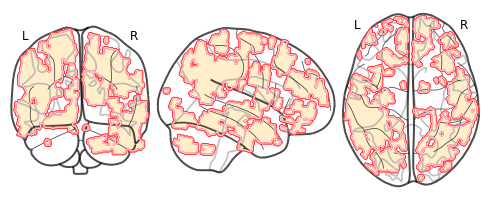

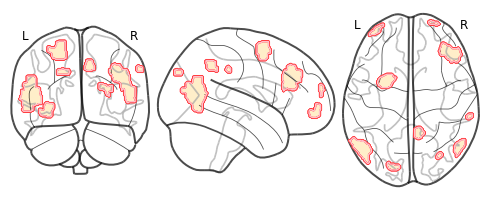

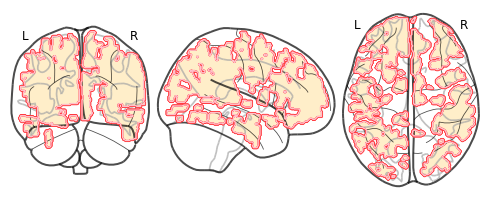

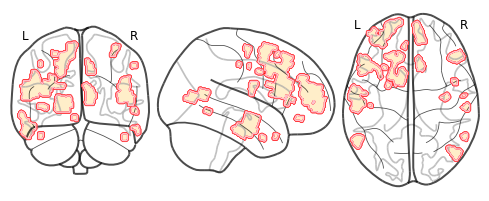

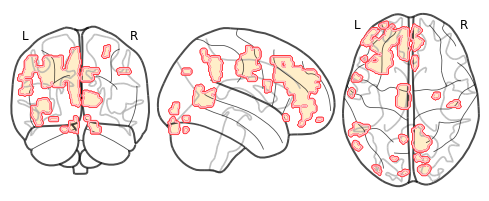

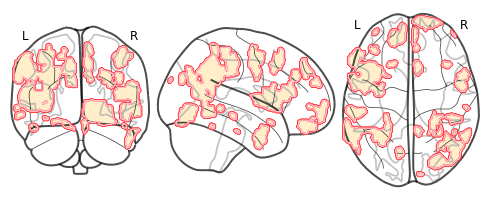

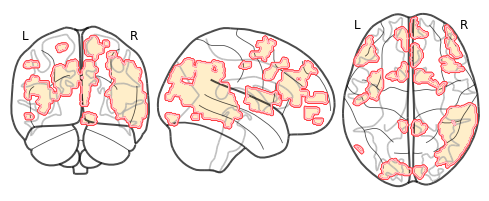

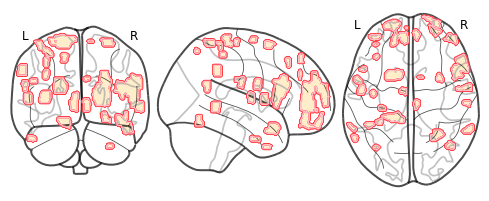

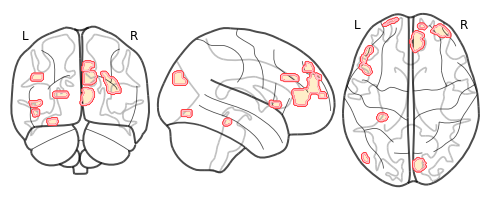

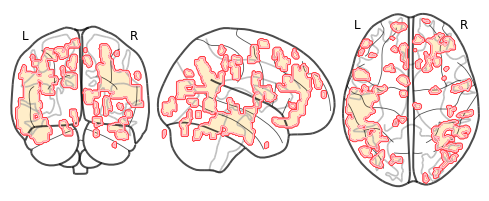

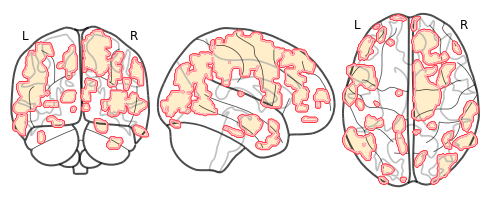

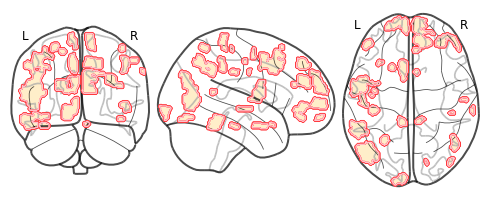

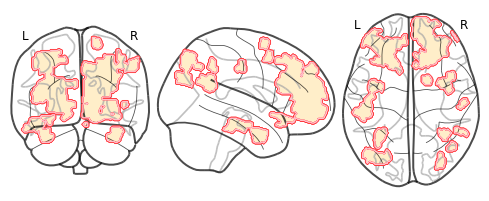

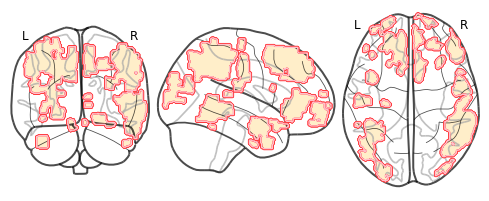

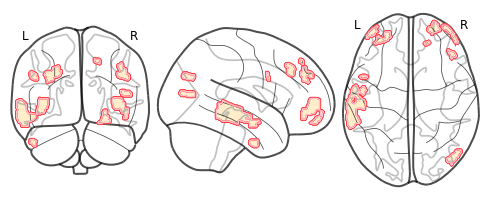

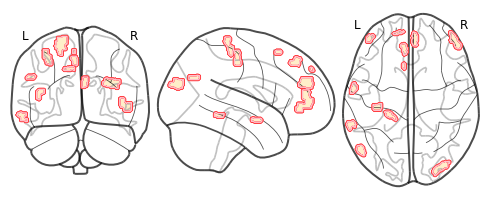

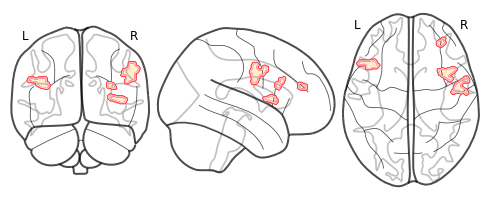

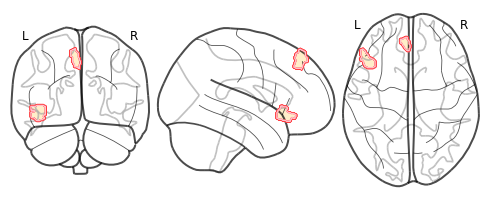

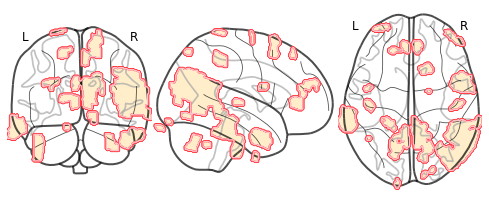

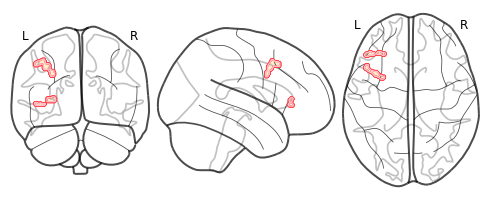

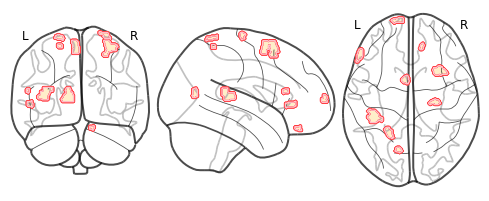

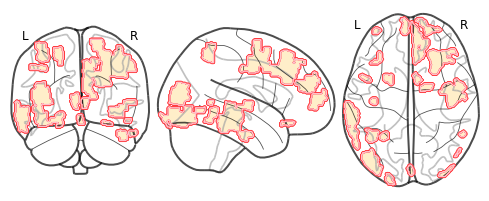

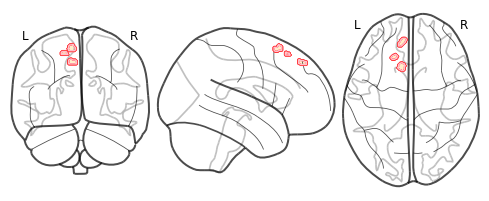

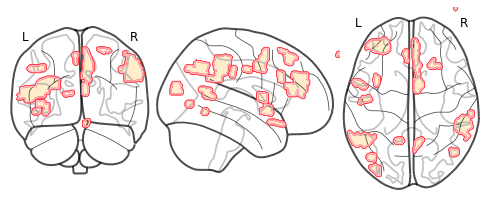

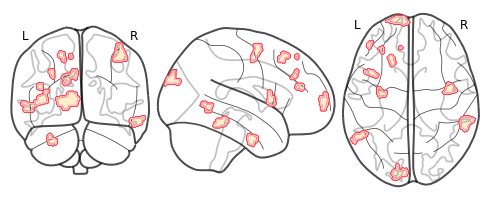

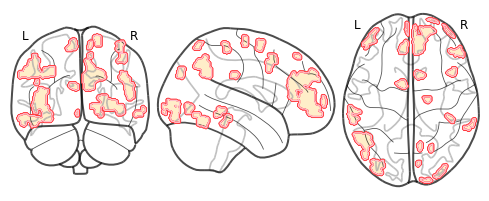

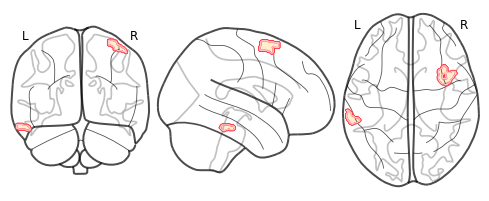

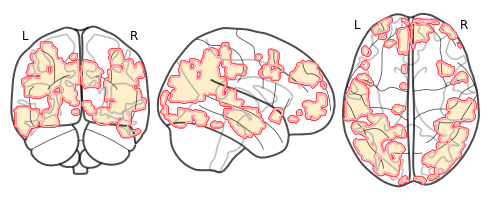

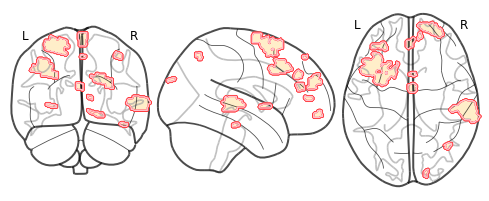

0

In [8]:
mod = 'mask_FL_reg2tp_thr0.5'
Analyzer.indiv_glass_brain(mod = mod, save_fig = True) # nilearn.glass

## 7. Individual tuber display with epileptogenic focus

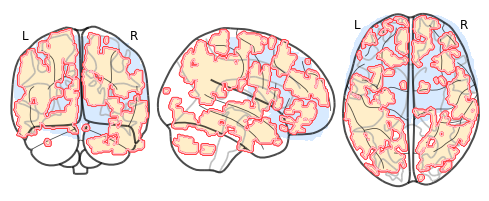

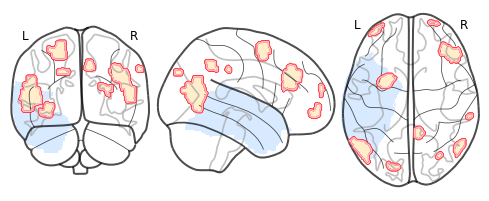

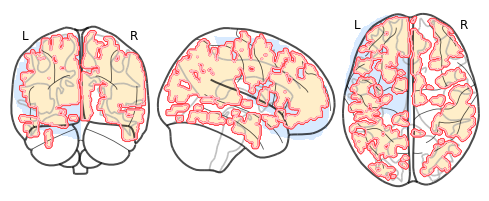

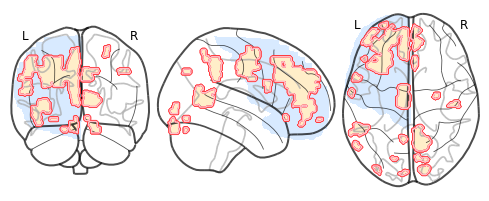

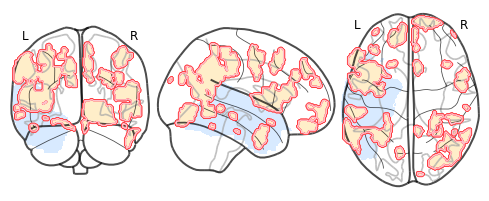

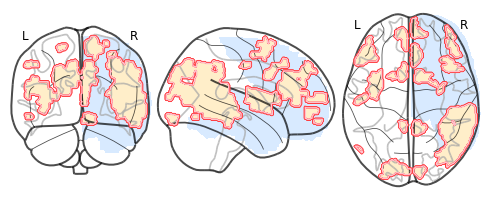

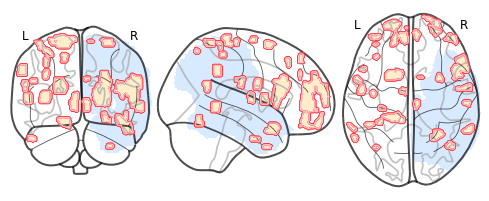

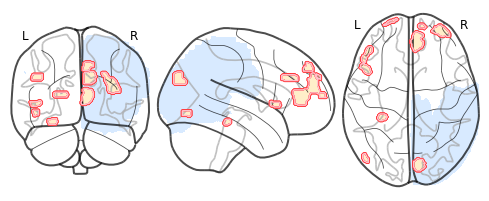

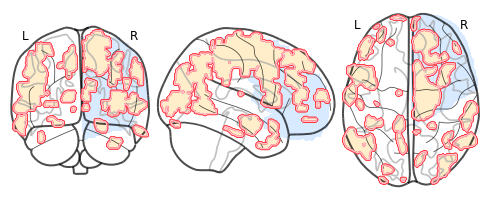

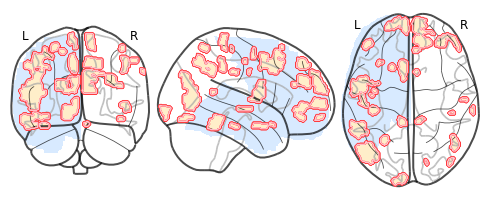

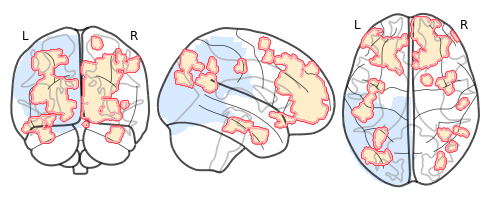

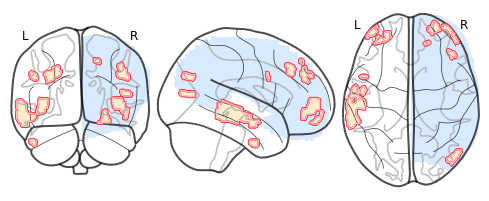

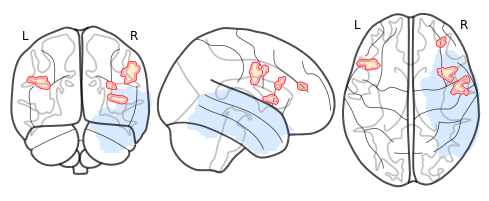

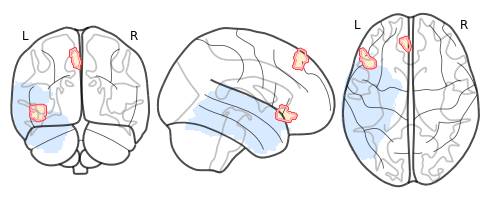

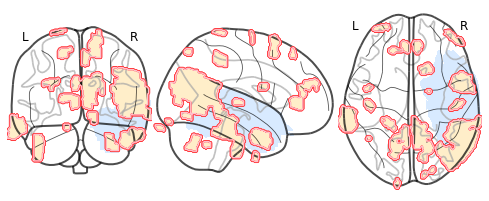

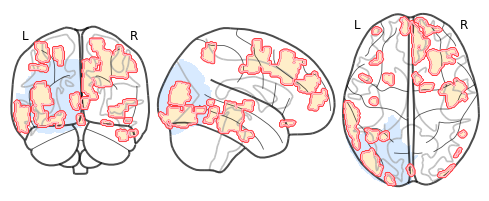

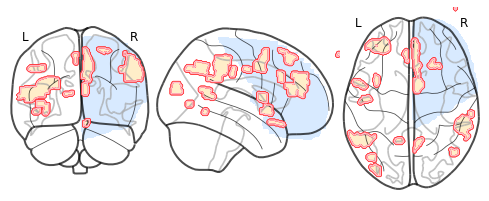

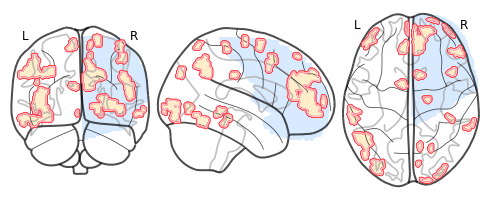

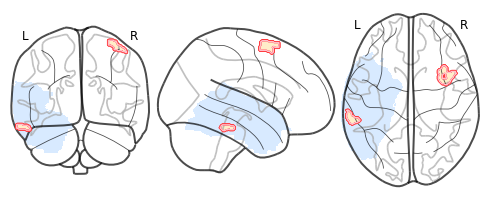

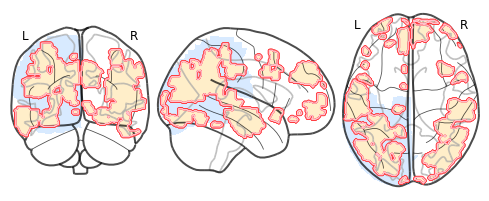

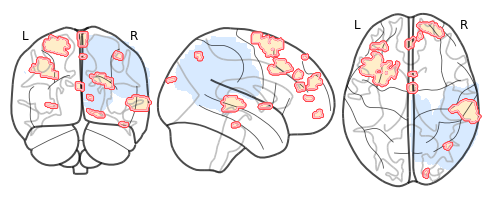

In [12]:
mod = 'mask_FL_reg2tp_thr0.5'
Analyzer.indiv_glass_brain_with_epileptogenic(mod = mod, save_fig = True) 